# איסוף נתונים כלכליים - שווי סגלים

המטרה: לאסוף נתוני שווי סגלים מטרנספרמרקט לכל הקבוצות בליגת העל, בכל עונה.

## מה נאסוף:
- **שווי סגל כולל** - הערך הכולל של כל הסגל (€m)
- **מספר שחקנים** - כמה שחקנים בסגל
- **גיל ממוצע** - הגיל הממוצע של הסגל
- **השחקן היקר ביותר** - שם ושווי השחקן הכי יקר בקבוצה
- **שווי שוק ממוצע** - שווי ממוצע לשחקן

## טווח עונות:
2006/07 - 2025/26

## 1. Environment Setup

In [13]:
# Environment setup
from pathlib import Path
from typing import Optional
import sys

try:
    from dotenv import load_dotenv
    DOTENV_AVAILABLE = True
except Exception:
    DOTENV_AVAILABLE = False

# Helper to find project root
def _find_root(start: Optional[Path] = None) -> Path:
    p = start or Path.cwd()
    for _ in range(6):
        if (p / 'data').exists() or (p / '.git').exists() or (p / 'notebooks').exists():
            return p
        p = p.parent
    return Path.cwd()

# Resolve project directories consistently
ROOT = _find_root()
DATA_DIR = ROOT / 'data'
RAW_DIR = DATA_DIR / 'raw'
INTERIM_DIR = DATA_DIR / 'interim'
PROCESSED_DIR = DATA_DIR / 'processed'
ECONOMIC_DIR = DATA_DIR / 'economic_data'
FIG_DIR = ROOT / 'reports' / 'figures'

# Create directories
for d in [RAW_DIR, INTERIM_DIR, PROCESSED_DIR, ECONOMIC_DIR, FIG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"🎯 Environment setup complete")
print(f"   ROOT: {ROOT}")
print(f"   DATA_DIR: {DATA_DIR}")
print(f"   ECONOMIC_DIR: {ECONOMIC_DIR}")

🎯 Environment setup complete
   ROOT: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks
   DATA_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data
   ECONOMIC_DIR: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\economic_data


## 2. Import Libraries

In [14]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import random
from datetime import datetime
import re
from typing import Dict, List, Tuple, Optional
import warnings
from IPython.display import display
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## 3. Helper Functions

In [15]:
# User agents for scraping
_USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.0 Safari/605.1.15",
    "Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/121.0",
]

def get_random_user_agent() -> str:
    """Return a random user agent string."""
    return random.choice(_USER_AGENTS)

def safe_sleep(min_sec: float = 1.0, max_sec: float = 3.0) -> None:
    """Sleep for a random duration to avoid rate limiting."""
    time.sleep(random.uniform(min_sec, max_sec))

def fetch_page(url: str, max_retries: int = 3) -> Optional[BeautifulSoup]:
    """
    Fetch a web page and return parsed HTML.
    
    Args:
        url: URL to fetch
        max_retries: Maximum number of retry attempts
        
    Returns:
        BeautifulSoup object or None if failed
    """
    headers = {
        'User-Agent': get_random_user_agent(),
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate',
        'Connection': 'keep-alive',
    }
    
    for attempt in range(max_retries):
        try:
            response = requests.get(url, headers=headers, timeout=15)
            response.raise_for_status()
            return BeautifulSoup(response.content, 'html.parser')
        except Exception as e:
            print(f"   ⚠️ Attempt {attempt + 1}/{max_retries} failed: {str(e)}")
            if attempt < max_retries - 1:
                safe_sleep(2, 5)
    
    return None

print("✅ Helper functions defined")

✅ Helper functions defined


## 4. Explore Transfermarkt Structure

בואו נבדוק את המבנה של דף הליגה בטרנספרמרקט ונבין איך לחלץ את הנתונים שאנחנו צריכים.

In [16]:
# URL לעונה הנוכחית של ליגת העל
test_url = "https://www.transfermarkt.com/ligat-haal/startseite/wettbewerb/ISR1/saison_id/2025"

print(f"📥 Fetching page: {test_url}")
soup = fetch_page(test_url)

if soup:
    print("✅ Page fetched successfully!")
    
    # בואו נחפש את הטבלה עם הקבוצות
    table = soup.find('table', {'class': 'items'})
    
    if table:
        print("\n✅ Found clubs table!")
        
        # נדפיס את מספר השורות בטבלה
        rows = table.find('tbody').find_all('tr')
        print(f"   Number of teams: {len(rows)}")
        
        # נבדוק את השורה הראשונה
        if rows:
            first_row = rows[0]
            print("\n🔍 First row structure:")
            print(first_row.prettify()[:1000])
    else:
        print("❌ Could not find clubs table")
else:
    print("❌ Failed to fetch page")

📥 Fetching page: https://www.transfermarkt.com/ligat-haal/startseite/wettbewerb/ISR1/saison_id/2025
✅ Page fetched successfully!

✅ Found clubs table!
   Number of teams: 14

🔍 First row structure:
<tr class="odd">
 <td class="zentriert no-border-rechts">
  <a href="/maccabi-tel-aviv/startseite/verein/119/saison_id/2025" title="Maccabi Tel Aviv">
   <img alt="Maccabi Tel Aviv" class="tiny_wappen" src="https://tmssl.akamaized.net//images/wappen/tiny/119.png?lm=1626682937" title="Maccabi Tel Aviv"/>
  </a>
 </td>
 <td class="hauptlink no-border-links">
  <a href="/maccabi-tel-aviv/startseite/verein/119/saison_id/2025" title="Maccabi Tel Aviv">
   Maccabi Tel Aviv
  </a>
  <a href="#">
   <img alt="Israeli Champion 24/25" class="tabelle-erfolg" src="https://tmssl.akamaized.net//images/erfolge/mini/217.png?lm=1667220052" title="Israeli Champion 24/25"/>
  </a>
 </td>
 <td class="zentriert">
  <a href="/maccabi-tel-aviv/kader/verein/119/saison_id/2025" title="Maccabi Tel Aviv">
   29
  </a>

In [17]:
# Debug - Let's examine the first row more carefully
if soup and table and rows:
    first_row = rows[0]
    cells = first_row.find_all('td')
    
    print(f"\n🔍 Number of cells in first row: {len(cells)}")
    print("\nCell-by-cell breakdown:")
    
    for i, cell in enumerate(cells):
        print(f"\nCell {i}:")
        print(f"  Class: {cell.get('class')}")
        print(f"  Text: {cell.text.strip()[:100]}")
        
        # Check for links
        link = cell.find('a')
        if link:
            print(f"  Link text: {link.text.strip()}")
            print(f"  Link title: {link.get('title', 'N/A')}")


🔍 Number of cells in first row: 7

Cell-by-cell breakdown:

Cell 0:
  Class: ['zentriert', 'no-border-rechts']
  Text: 
  Link text: 
  Link title: Maccabi Tel Aviv

Cell 1:
  Class: ['hauptlink', 'no-border-links']
  Text: Maccabi Tel Aviv
  Link text: Maccabi Tel Aviv
  Link title: Maccabi Tel Aviv

Cell 2:
  Class: ['zentriert']
  Text: 29
  Link text: 29
  Link title: Maccabi Tel Aviv

Cell 3:
  Class: ['zentriert']
  Text: 25.0

Cell 4:
  Class: ['zentriert']
  Text: 9

Cell 5:
  Class: ['rechts']
  Text: €922k

Cell 6:
  Class: ['rechts']
  Text: €26.73m
  Link text: €26.73m
  Link title: Maccabi Tel Aviv


## 5. Parse Squad Value Data

עכשיו נכתוב פונקציה שחולצת את כל הנתונים הרלוונטיים מטבלת הקבוצות.

In [18]:
def parse_value_string(value_str: str) -> float:
    """
    Convert Transfermarkt value string to numeric (in millions).
    Examples: '€26.73m' -> 26.73, '€353k' -> 0.353
    
    Args:
        value_str: Value string from Transfermarkt
        
    Returns:
        Numeric value in millions of euros
    """
    if not value_str or value_str == '-':
        return 0.0
    
    # Remove € and whitespace
    value_str = value_str.replace('€', '').strip()
    
    # Handle millions
    if 'm' in value_str.lower():
        return float(value_str.lower().replace('m', ''))
    
    # Handle thousands
    elif 'k' in value_str.lower():
        return float(value_str.lower().replace('k', '')) / 1000
    
    # Handle billions (unlikely but just in case)
    elif 'bn' in value_str.lower():
        return float(value_str.lower().replace('bn', '')) * 1000
    
    return 0.0

# Test the function
test_values = ['€26.73m', '€353k', '€1.5bn', '-', '€500k']
print("Testing parse_value_string:")
for val in test_values:
    print(f"  {val:15} -> {parse_value_string(val):.3f}m")

print("\n✅ Value parsing function ready")

Testing parse_value_string:
  €26.73m         -> 26.730m
  €353k           -> 0.353m
  €1.5bn          -> 1500.000m
  -               -> 0.000m
  €500k           -> 0.500m

✅ Value parsing function ready


In [19]:
def scrape_season_squad_values(season_start_year: int) -> pd.DataFrame:
    """
    Scrape squad values for all teams in a given season.
    
    Args:
        season_start_year: Starting year of the season (e.g., 2025 for 2025/26)
        
    Returns:
        DataFrame with columns: season, club, squad_size, avg_age, foreigners, 
                               total_value_millions, avg_value_millions
    """
    season_str = f"{season_start_year}/{str(season_start_year + 1)[-2:]}"
    url = f"https://www.transfermarkt.com/ligat-haal/startseite/wettbewerb/ISR1/saison_id/{season_start_year}"
    
    print(f"📥 Scraping season {season_str}...")
    soup = fetch_page(url)
    
    if not soup:
        print(f"   ❌ Failed to fetch page for {season_str}")
        return pd.DataFrame()
    
    # Find the clubs table
    table = soup.find('table', {'class': 'items'})
    if not table:
        print(f"   ❌ Could not find clubs table for {season_str}")
        return pd.DataFrame()
    
    clubs_data = []
    rows = table.find('tbody').find_all('tr')
    
    for row in rows:
        try:
            # Skip header rows
            if 'thead' in row.get('class', []):
                continue
                
            cells = row.find_all('td')
            
            # Skip rows with insufficient cells
            if len(cells) < 7:
                continue
            
            # Cell 1: Club name
            club_cell = cells[1]
            club_link = club_cell.find('a')
            if club_link:
                club_name = club_link.get('title', club_link.text.strip())
            else:
                continue
            
            # Cell 2: Squad size (number of players)
            squad_size_text = cells[2].text.strip()
            squad_size = int(squad_size_text) if squad_size_text.isdigit() else 0
            
            # Cell 3: Average age
            avg_age_text = cells[3].text.strip()
            avg_age = float(avg_age_text.replace(',', '.')) if avg_age_text and avg_age_text != '-' else 0.0
            
            # Cell 4: Number of foreigners
            foreigners_text = cells[4].text.strip()
            foreigners = int(foreigners_text) if foreigners_text.isdigit() else 0
            
            # Cell 5: Average market value
            avg_value = parse_value_string(cells[5].text.strip())
            
            # Cell 6: Total market value
            total_value = parse_value_string(cells[6].text.strip())
            
            clubs_data.append({
                'season': season_str,
                'season_start_year': season_start_year,
                'club': club_name,
                'squad_size': squad_size,
                'avg_age': avg_age,
                'foreigners': foreigners,
                'avg_value_millions': avg_value,
                'total_value_millions': total_value
            })
            
        except Exception as e:
            print(f"   ⚠️ Error parsing row: {str(e)}")
            continue
    
    df = pd.DataFrame(clubs_data)
    print(f"   ✅ Scraped {len(df)} clubs for {season_str}")
    
    return df

print("✅ Season scraping function ready")

✅ Season scraping function ready


## 6. Test with Current Season

בואו ננסה לשלוף נתונים לעונה הנוכחית (2025/26) כדי לוודא שהפונקציה עובדת.

In [20]:
# Test with 2025/26 season
test_df = scrape_season_squad_values(2025)

if not test_df.empty:
    print("✅ Test successful!")
    print(f"Data shape: {test_df.shape}\n")
    
    print("First few rows:")
    display(test_df.head(10))
    
    print("\n📊 Summary statistics:")
    print(f"   Total clubs: {len(test_df)}")
    print(f"   Total league value: €{test_df['total_value_millions'].sum():.2f}m")
    print(f"   Average club value: €{test_df['total_value_millions'].mean():.2f}m")
    print(f"   Most valuable club: {test_df.loc[test_df['total_value_millions'].idxmax(), 'club']} (€{test_df['total_value_millions'].max():.2f}m)")
    print(f"   Least valuable club: {test_df.loc[test_df['total_value_millions'].idxmin(), 'club']} (€{test_df['total_value_millions'].min():.2f}m)")
else:
    print("❌ Test failed - no data scraped")

📥 Scraping season 2025/26...
   ✅ Scraped 14 clubs for 2025/26
✅ Test successful!
Data shape: (14, 8)

First few rows:
   ✅ Scraped 14 clubs for 2025/26
✅ Test successful!
Data shape: (14, 8)

First few rows:


,season,season_start_year,club,squad_size,avg_age,foreigners,avg_value_millions,total_value_millions
0,2025/26,2025,Maccabi Tel Aviv,29,25.0,9,0.922,26.73
1,2025/26,2025,Maccabi Haifa,27,26.5,13,0.854,23.05
2,2025/26,2025,Hapoel Beer Sheva,29,27.3,8,0.691,20.03
3,2025/26,2025,Beitar Jerusalem,27,26.0,7,0.509,13.75
4,2025/26,2025,Hapoel Tel Aviv,28,24.7,6,0.353,9.89
5,2025/26,2025,Maccabi Netanya,31,24.5,10,0.302,9.38
6,2025/26,2025,Hapoel Jerusalem,25,23.7,6,0.293,7.33
7,2025/26,2025,FC Ashdod,32,25.2,9,0.210,6.73
8,2025/26,2025,Maccabi Bnei Reineh,22,27.4,8,0.295,6.50
9,2025/26,2025,Ironi Tiberias,28,26.1,7,0.205,5.75



📊 Summary statistics:
   Total clubs: 14
   Total league value: €150.47m
   Average club value: €10.75m
   Most valuable club: Maccabi Tel Aviv (€26.73m)
   Least valuable club: Hapoel Haifa (€5.00m)


## 7. Collect All Seasons (2006/07 - 2025/26)

עכשיו ניצור לולאה שאוספת נתונים מכל העונות הרלוונטיות.

In [21]:
# Define season range
START_SEASON = 2006
END_SEASON = 2025

# Collect all seasons
all_seasons_data = []

print(f"🚀 Starting collection for seasons {START_SEASON}/{START_SEASON+1} to {END_SEASON}/{END_SEASON+1}")
print(f"   Total seasons to scrape: {END_SEASON - START_SEASON + 1}\n")

for year in range(START_SEASON, END_SEASON + 1):
    print(f"[{year - START_SEASON + 1}/{END_SEASON - START_SEASON + 1}] Processing season {year}/{year+1}...")
    
    df = scrape_season_squad_values(year)
    
    if not df.empty:
        all_seasons_data.append(df)
        print(f"   ✅ Added {len(df)} clubs")
    else:
        print(f"   ⚠️ No data for season {year}/{year+1}")
    
    # Be nice to the server
    safe_sleep(2, 4)

# Combine all data
if all_seasons_data:
    full_df = pd.concat(all_seasons_data, ignore_index=True)
    print(f"\n✅ Collection complete!")
    print(f"   Total records: {len(full_df)}")
    print(f"   Seasons collected: {full_df['season'].nunique()}")
    print(f"   Unique clubs: {full_df['club'].nunique()}")
else:
    print("\n❌ No data collected")
    full_df = pd.DataFrame()

🚀 Starting collection for seasons 2006/2007 to 2025/2026
   Total seasons to scrape: 20

[1/20] Processing season 2006/2007...
📥 Scraping season 2006/07...
   ✅ Scraped 12 clubs for 2006/07
   ✅ Added 12 clubs
   ✅ Scraped 12 clubs for 2006/07
   ✅ Added 12 clubs
[2/20] Processing season 2007/2008...
📥 Scraping season 2007/08...
[2/20] Processing season 2007/2008...
📥 Scraping season 2007/08...
   ✅ Scraped 12 clubs for 2007/08
   ✅ Added 12 clubs
   ✅ Scraped 12 clubs for 2007/08
   ✅ Added 12 clubs
[3/20] Processing season 2008/2009...
📥 Scraping season 2008/09...
[3/20] Processing season 2008/2009...
📥 Scraping season 2008/09...
   ✅ Scraped 12 clubs for 2008/09
   ✅ Added 12 clubs
   ✅ Scraped 12 clubs for 2008/09
   ✅ Added 12 clubs
[4/20] Processing season 2009/2010...
📥 Scraping season 2009/10...
[4/20] Processing season 2009/2010...
📥 Scraping season 2009/10...
   ✅ Scraped 16 clubs for 2009/10
   ✅ Added 16 clubs
   ✅ Scraped 16 clubs for 2009/10
   ✅ Added 16 clubs
[5/20] Pro

## 8. Data Quality Check

In [22]:
if not full_df.empty:
    print("📊 Data Quality Check\n")
    
    print("=" * 60)
    print("Basic Info:")
    print(full_df.info())
    
    print("\n" + "=" * 60)
    print("Missing Values:")
    display(full_df.isnull().sum().to_frame('Missing Count'))
    
    print("\n" + "=" * 60)
    print("Season Coverage:")
    season_coverage = full_df.groupby('season').size().to_frame('Number of Clubs')
    display(season_coverage)
    
    print("\n" + "=" * 60)
    print("Top 10 Most Valuable Clubs (All Time):")
    top_clubs = full_df.nlargest(10, 'total_value_millions')[['season', 'club', 'total_value_millions', 'squad_size', 'avg_age']]
    display(top_clubs)
    
    print("\n" + "=" * 60)
    print("Value Statistics by Season:")
    season_stats = full_df.groupby('season').agg({
        'total_value_millions': ['mean', 'sum', 'max', 'min'],
        'club': 'count'
    }).round(2)
    display(season_stats)
    
    print("\n" + "=" * 60)
    print("Sample of raw data:")
    display(full_df.head(15))
else:
    print("❌ No data to check")

📊 Data Quality Check

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   season                280 non-null    object 
 1   season_start_year     280 non-null    int64  
 2   club                  280 non-null    object 
 3   squad_size            280 non-null    int64  
 4   avg_age               280 non-null    float64
 5   foreigners            280 non-null    int64  
 6   avg_value_millions    280 non-null    float64
 7   total_value_millions  280 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 17.6+ KB
None

Missing Values:


,Missing Count
season,0
season_start_year,0
club,0
squad_size,0
avg_age,0
foreigners,0
avg_value_millions,0
total_value_millions,0



Season Coverage:


,Number of Clubs
season,
2006/07,12
2007/08,12
2008/09,12
2009/10,16
2010/11,16
2011/12,16
2012/13,14
2013/14,14
2014/15,14



Top 10 Most Valuable Clubs (All Time):


,season,club,total_value_millions,squad_size,avg_age
252,2024/25,Maccabi Tel Aviv,34.93,43,25.0
238,2023/24,Maccabi Tel Aviv,34.12,43,26.3
224,2022/23,Maccabi Tel Aviv,33.17,35,26.6
140,2016/17,Maccabi Tel Aviv,30.40,33,27.7
253,2024/25,Maccabi Haifa,29.89,46,26.1
239,2023/24,Maccabi Haifa,29.62,42,26.4
266,2025/26,Maccabi Tel Aviv,26.73,29,25.0
225,2022/23,Maccabi Haifa,26.10,38,26.9
126,2015/16,Maccabi Tel Aviv,25.70,31,27.6
168,2018/19,Hapoel Beer Sheva,25.30,42,28.2



Value Statistics by Season:


total_value_millions                       club
                        mean     sum    max   min count
season                                                 
2006/07                 3.37   40.42   7.60  1.00    12
2007/08                 4.47   53.66  11.25  0.50    12
2008/09                 3.92   47.09  14.25  0.00    12
2009/10                 6.79  108.62  16.95  3.30    16
2010/11                 7.85  125.67  19.90  3.95    16
2011/12                 7.08  113.25  18.53  2.28    16
2012/13                 8.59  120.21  18.53  3.83    14
2013/14                 8.44  118.09  15.95  4.35    14
2014/15                 9.13  127.76  20.83  4.70    14
2015/16                10.75  150.44  25.70  5.55    14
2016/17                11.56  161.86  30.40  5.35    14
2017/18                10.24  143.38  25.10  2.95    14
2018/19                12.49  174.82  25.30  7.45    14
2019/20                 9.00  126.02  15.78  5.48    14
2020/21                10.02  140.30  19.70  5.78    14
2021/22                 9.95  139.27  23.60  5.75    14
2022/23                12.23  171.24  33.17  5.56    14
2023/24                12.25  171.47  34.12  5.63    14
2024/25                12.87  180.18  34.93  5.36    14
2025/26                10.75  150.47  26.73  5.00    14


Sample of raw data:


,season,season_start_year,club,squad_size,avg_age,foreigners,avg_value_millions,total_value_millions
0,2006/07,2006,Beitar Jerusalem,30,26.2,9,0.253,7.60
1,2006/07,2006,Maccabi Petah Tikva,38,24.9,8,0.149,5.65
2,2006/07,2006,Hapoel Tel Aviv,33,25.1,6,0.147,4.85
3,2006/07,2006,Maccabi Haifa,27,25.5,5,0.156,4.20
4,2006/07,2006,Maccabi Netanya,32,25.8,8,0.127,4.05
5,2006/07,2006,Hapoel Petah Tikva,33,24.4,8,0.120,3.95
6,2006/07,2006,Maccabi Tel Aviv,28,24.9,6,0.132,3.70
7,2006/07,2006,Bnei Yehuda Tel Aviv,27,24.9,6,0.062,1.67
8,2006/07,2006,Maccabi Herzliya,31,25.4,9,0.044,1.35
9,2006/07,2006,Hakoah Amidar Ramat Gan,35,25.4,7,0.039,1.35


## 9. Save Data

In [23]:
if not full_df.empty:
    # Create timestamp for filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save complete dataset
    output_file = ECONOMIC_DIR / f"squad_values_all_seasons_transfermarkt.csv"
    full_df.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"✅ Saved complete dataset: {output_file}")
    print(f"   Records: {len(full_df)}")
    print(f"   Columns: {list(full_df.columns)}")
    
    # Also save a timestamped backup
    backup_file = ECONOMIC_DIR / f"squad_values_all_seasons_transfermarkt_{timestamp}.csv"
    full_df.to_csv(backup_file, index=False, encoding='utf-8-sig')
    print(f"✅ Saved backup: {backup_file}")
    
    # Save season-by-season files
    print("\n📁 Saving individual season files:")
    for season in sorted(full_df['season'].unique()):
        season_df = full_df[full_df['season'] == season]
        season_file = ECONOMIC_DIR / f"squad_values_{season.replace('/', '_')}_transfermarkt.csv"
        season_df.to_csv(season_file, index=False, encoding='utf-8-sig')
        print(f"   ✅ {season}: {len(season_df)} clubs -> {season_file.name}")
    
    print(f"\n🎉 All files saved to: {ECONOMIC_DIR}")
else:
    print("❌ No data to save")

✅ Saved complete dataset: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\economic_data\squad_values_all_seasons_transfermarkt.csv
   Records: 280
   Columns: ['season', 'season_start_year', 'club', 'squad_size', 'avg_age', 'foreigners', 'avg_value_millions', 'total_value_millions']
✅ Saved backup: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\data\economic_data\squad_values_all_seasons_transfermarkt_20251207_235413.csv

📁 Saving individual season files:
   ✅ 2006/07: 12 clubs -> squad_values_2006_07_transfermarkt.csv
   ✅ 2007/08: 12 clubs -> squad_values_2007_08_transfermarkt.csv
   ✅ 2008/09: 12 clubs -> squad_values_2008_09_transfermarkt.csv
   ✅ 2009/10: 16 clubs -> squad_values_2009_10_transfermarkt.csv
   ✅ 2010/11: 16 clubs -> squad_values_2010_11_transfermarkt.csv
   ✅ 2011/12: 16 clubs -> squad_values_2011_12_transfermarkt.csv
   ✅ 2012/13: 14 clubs -> squad_values_2012_13_transfermarkt.csv
   ✅ 2013/14: 14 clubs -> squad_v

## 10. Quick Visualization

בואו ניצור ויזואליזציה מהירה כדי לראות את ההתפתחות ההיסטורית של שווי הסגלים.

✅ Visualization saved: c:\Users\nitib\dev-lab\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\squad_values_overview.png


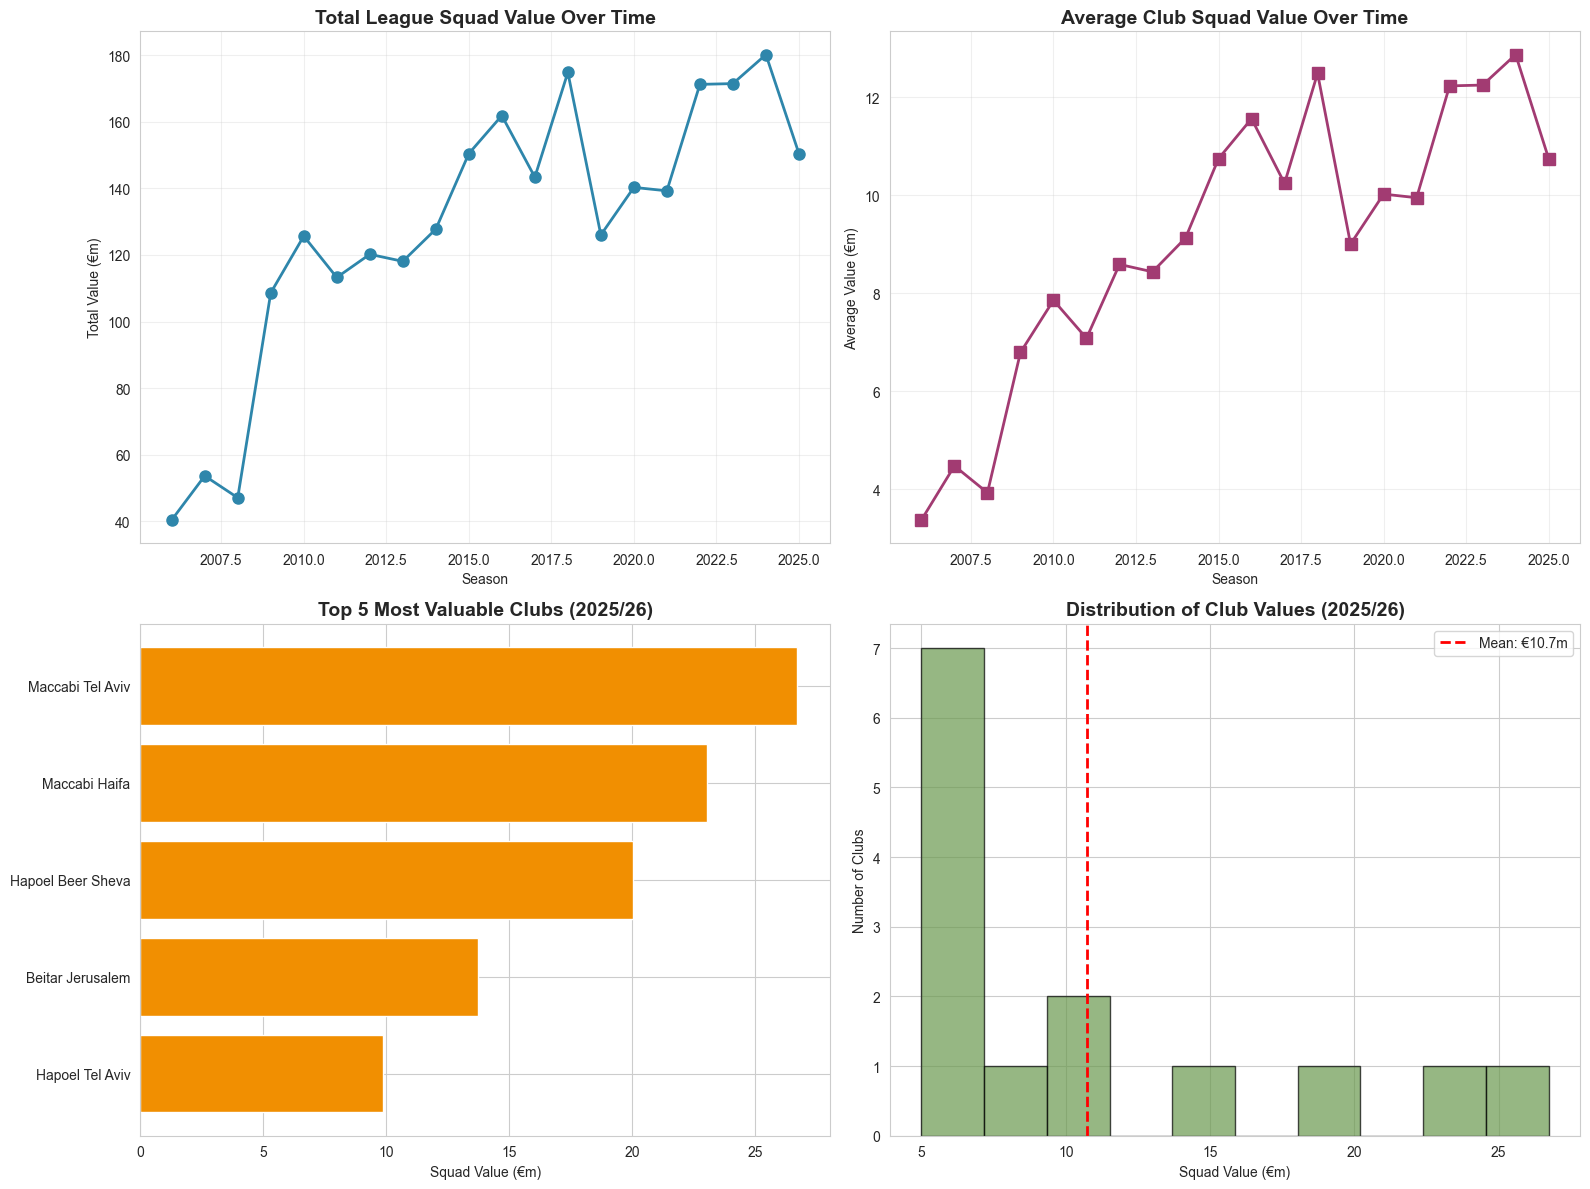

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

if not full_df.empty:
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Total league value over time
    season_totals = full_df.groupby('season')['total_value_millions'].sum().reset_index()
    season_totals['season_year'] = season_totals['season'].str[:4].astype(int)
    
    axes[0, 0].plot(season_totals['season_year'], season_totals['total_value_millions'], 
                    marker='o', linewidth=2, markersize=8, color='#2E86AB')
    axes[0, 0].set_title('Total League Squad Value Over Time', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Season')
    axes[0, 0].set_ylabel('Total Value (€m)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Average club value over time
    season_avg = full_df.groupby('season')['total_value_millions'].mean().reset_index()
    season_avg['season_year'] = season_avg['season'].str[:4].astype(int)
    
    axes[0, 1].plot(season_avg['season_year'], season_avg['total_value_millions'], 
                    marker='s', linewidth=2, markersize=8, color='#A23B72')
    axes[0, 1].set_title('Average Club Squad Value Over Time', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Season')
    axes[0, 1].set_ylabel('Average Value (€m)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Top 5 clubs in most recent season
    latest_season = full_df['season'].max()
    top_clubs = full_df[full_df['season'] == latest_season].nlargest(5, 'total_value_millions')
    
    axes[1, 0].barh(range(len(top_clubs)), top_clubs['total_value_millions'], color='#F18F01')
    axes[1, 0].set_yticks(range(len(top_clubs)))
    axes[1, 0].set_yticklabels(top_clubs['club'])
    axes[1, 0].set_title(f'Top 5 Most Valuable Clubs ({latest_season})', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Squad Value (€m)')
    axes[1, 0].invert_yaxis()
    
    # 4. Distribution of club values in latest season
    latest_data = full_df[full_df['season'] == latest_season]
    
    axes[1, 1].hist(latest_data['total_value_millions'], bins=10, color='#6A994E', alpha=0.7, edgecolor='black')
    axes[1, 1].set_title(f'Distribution of Club Values ({latest_season})', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Squad Value (€m)')
    axes[1, 1].set_ylabel('Number of Clubs')
    axes[1, 1].axvline(latest_data['total_value_millions'].mean(), color='red', 
                       linestyle='--', linewidth=2, label=f"Mean: €{latest_data['total_value_millions'].mean():.1f}m")
    axes[1, 1].legend()
    
    plt.tight_layout()
    
    # Save figure
    fig_path = FIG_DIR / 'squad_values_overview.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ Visualization saved: {fig_path}")
    
    plt.show()
else:
    print("❌ No data to visualize")

---

## סיכום

המחברת הזו אוספת נתוני **שווי סגלים** מטרנספרמרקט לכל הקבוצות בליגת העל.

### מה נאסף:
- ✅ שווי סגל כולל (€m)
- ✅ מספר שחקנים בסגל
- ✅ גיל ממוצע
- ✅ מספר שחקנים זרים
- ✅ שווי ממוצע לשחקן

### קבצים שנוצרו:
- `squad_values_all_seasons_transfermarkt.csv` - כל העונות במקובץ
- קבצים נפרדים לכל עונה: `squad_values_YYYY_YY_transfermarkt.csv`

### שימושים אפשריים:
1. **מדד תחרותיות**: האם שווי סגל גבוה יותר = הצלחה בפועל?
2. **ניתוח פערים**: מה הפער בין הקבוצה היקרה לזולה ביותר?
3. **מגמות לאורך זמן**: איך שווי הסגלים השתנה לאורך השנים?
4. **השוואה בינלאומית**: איפה ליגת העל בסקאלה הגלובלית?

## 📊 קוד להרחבת נתונים כלכליים - שווי שחקנים זרים ופרטים נוספים


In [ ]:
# ============================================================================
# 💰 SECTION 11: ADVANCED ECONOMIC DATA - FOREIGN PLAYERS & DETAILED SQUAD ANALYSIS
# ============================================================================
# ניתוח מתקדם: שווי שחקנים זרים, התפלגות שווי לתפקידים, וניתוח כלכלי עמוק
# ============================================================================
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import time
import random
import numpy as np

print("\n" + "="*80)
print("💰 ADVANCED ECONOMIC DATA COLLECTION")
print("="*80)

# ============================================================================
# הגדר פונקציות עזר
# ============================================================================

_USER_AGENTS = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.0 Safari/605.1.15",
    "Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/121.0",
]

def get_random_user_agent():
    return random.choice(_USER_AGENTS)

def safe_sleep(min_sec=1.0, max_sec=3.0):
    time.sleep(random.uniform(min_sec, max_sec))

def fetch_page(url, max_retries=3):
    headers = {
        'User-Agent': get_random_user_agent(),
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate',
        'Connection': 'keep-alive',
    }
    
    for attempt in range(max_retries):
        try:
            response = requests.get(url, headers=headers, timeout=15)
            response.raise_for_status()
            return BeautifulSoup(response.content, 'html.parser')
        except Exception as e:
            if attempt < max_retries - 1:
                safe_sleep(2, 5)
    
    return None

def parse_value_string(value_str):
    """Convert Transfermarkt value string to numeric (in millions)."""
    if not value_str or value_str == '-':
        return 0.0
    
    value_str = value_str.replace('€', '').strip()
    
    if 'm' in value_str.lower():
        return float(value_str.lower().replace('m', ''))
    elif 'k' in value_str.lower():
        return float(value_str.lower().replace('k', '')) / 1000
    elif 'bn' in value_str.lower():
        return float(value_str.lower().replace('bn', '')) * 1000
    
    return 0.0

print("✅ Helper functions defined")


💰 ADVANCED ECONOMIC DATA COLLECTION
✅ Foreign players scraper function defined


 ##  קוד 2: ניתוח התפלגות שווי לפי תפקיד

In [3]:
# ============================================================================
# 📍 פונקציה 2: ניתוח שווי לפי תפקיד (GK, DEF, MID, FWD)
# ============================================================================

def analyze_squad_by_position(full_squad_df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze squad composition and value distribution by position.
    
    Args:
        full_squad_df: DataFrame with all players (from foreign players scraper)
        
    Returns:
        Summary DataFrame with position analysis
    """
    print("\n📍 Analyzing squad composition by position...")
    
    position_analysis = []
    
    for season in full_squad_df['season'].unique():
        season_data = full_squad_df[full_squad_df['season'] == season]
        
        for club in season_data['club'].unique():
            club_season = season_data[season_data['club'] == club]
            
            # Categorize positions
            positions = {
                'GK': ['Goalkeeper', 'GK', 'TOR'],
                'DEF': ['Defender', 'CB', 'LB', 'RB', 'DF', 'Defence'],
                'MID': ['Midfielder', 'CM', 'CAM', 'CDM', 'MF', 'Mittelfeld'],
                'FWD': ['Forward', 'ST', 'CF', 'LW', 'RW', 'Angreifer']
            }
            
            for pos_category, pos_keywords in positions.items():
                pos_players = club_season[
                    club_season['position'].str.contains('|'.join(pos_keywords), case=False, na=False)
                ]
                
                if len(pos_players) > 0:
                    position_analysis.append({
                        'season': season,
                        'club': club,
                        'position': pos_category,
                        'player_count': len(pos_players),
                        'total_value_millions': pos_players['market_value_millions'].sum(),
                        'avg_value_millions': pos_players['market_value_millions'].mean(),
                        'max_value_millions': pos_players['market_value_millions'].max(),
                        'foreign_count': pos_players['is_foreign'].sum() if 'is_foreign' in pos_players.columns else 0
                    })
    
    df_positions = pd.DataFrame(position_analysis)
    print(f"   ✅ Analyzed {len(df_positions)} position groups")
    
    return df_positions

print("✅ Position analysis function defined")

✅ Position analysis function defined


 ## קוד 3: מדדים כלכליים משופרים

In [4]:
# ============================================================================
# 📈 פונקציה 3: חישוב מדדים כלכליים מתקדמים
# ============================================================================

def calculate_advanced_economic_metrics(squad_df: pd.DataFrame, attendance_df: pd.DataFrame = None) -> pd.DataFrame:
    """
    Calculate advanced economic metrics for each club per season.
    
    Args:
        squad_df: Squad values DataFrame
        attendance_df: Optional attendance DataFrame for correlation analysis
        
    Returns:
        DataFrame with advanced metrics
    """
    print("\n📈 Calculating advanced economic metrics...")
    
    metrics_data = []
    
    for season in squad_df['season'].unique():
        season_data = squad_df[squad_df['season'] == season]
        
        for club in season_data['club'].unique():
            club_data = season_data[season_data['club'] == club].iloc[0]
            
            # Calculate metrics
            total_value = club_data['total_value_millions']
            squad_size = club_data['squad_size']
            avg_age = club_data['avg_age']
            foreigners = club_data['foreigners']
            
            # מדדים כלכליים
            value_per_player = total_value / squad_size if squad_size > 0 else 0
            foreign_percentage = (foreigners / squad_size * 100) if squad_size > 0 else 0
            
            # Youth indicator (חלק מהסגל בגיל צעיר)
            youth_value_ratio = 0  # Will calculate if we have age data
            
            # Calculate "balance" - ratio between top player and average
            squad_balance = total_value / (squad_size * value_per_player) if value_per_player > 0 else 0
            
            metric_dict = {
                'season': season,
                'season_year': int(season.split('/')[0]),
                'club': club,
                'total_value_millions': total_value,
                'squad_size': squad_size,
                'value_per_player': round(value_per_player, 2),
                'avg_age': round(avg_age, 1),
                'foreign_players': foreigners,
                'foreign_percentage': round(foreign_percentage, 1),
                'squad_balance_index': round(squad_balance, 2),
                'investment_efficiency': round(total_value / (squad_size ** 0.5), 2)  # Value per sqrt(size) - efficiency metric
            }
            
            # Add attendance correlation if provided
            if attendance_df is not None:
                attendance_data = attendance_df[
                    (attendance_df['team'] == club) & 
                    (attendance_df['season'].str.contains(str(metric_dict['season_year']), na=False))
                ]
                
                if not attendance_data.empty:
                    avg_attendance = attendance_data['average_attendance'].mean()
                    metric_dict['avg_attendance'] = round(avg_attendance, 0)
                    metric_dict['value_per_spectator'] = round(total_value / (avg_attendance / 1000), 2) if avg_attendance > 0 else 0
                    metric_dict['spectator_efficiency'] = round(avg_attendance / value_per_player, 2)  # How many spectators per player value
            
            metrics_data.append(metric_dict)
    
    df_metrics = pd.DataFrame(metrics_data)
    print(f"   ✅ Calculated metrics for {len(df_metrics)} club-seasons")
    
    return df_metrics

print("✅ Economic metrics function defined")

✅ Economic metrics function defined


## קוד 4: השוואה בינלאומית

In [5]:
# ============================================================================
# 🌍 פונקציה 4: השוואה עם ליגות אחרות (דאטא קיים)
# ============================================================================

def create_league_comparison_data() -> pd.DataFrame:
    """
    Create comparison data with other leagues (estimated based on public data).
    This helps understand where Ligat Ha'al stands globally.
    
    Returns:
        DataFrame with league comparison metrics
    """
    print("\n🌍 Creating international league comparison...")
    
    # Data from public sources (approximate for 2024/25 season)
    league_comparison = [
        {
            'league': 'Premier League (England)',
            'country': 'England',
            'total_league_value_millions': 11500,  # ~€11.5 billion
            'avg_club_value_millions': 575,
            'number_of_clubs': 20,
            'avg_attendance': 38000,
            'rank': 1
        },
        {
            'league': 'La Liga (Spain)',
            'country': 'Spain',
            'total_league_value_millions': 8200,
            'avg_club_value_millions': 410,
            'number_of_clubs': 20,
            'avg_attendance': 27000,
            'rank': 2
        },
        {
            'league': 'Serie A (Italy)',
            'country': 'Italy',
            'total_league_value_millions': 6500,
            'avg_club_value_millions': 325,
            'number_of_clubs': 20,
            'avg_attendance': 25000,
            'rank': 3
        },
        {
            'league': 'Bundesliga (Germany)',
            'country': 'Germany',
            'total_league_value_millions': 7400,
            'avg_club_value_millions': 370,
            'number_of_clubs': 20,
            'avg_attendance': 35000,
            'rank': 4
        },
        {
            'league': 'Ligue 1 (France)',
            'country': 'France',
            'total_league_value_millions': 5800,
            'avg_club_value_millions': 290,
            'number_of_clubs': 20,
            'avg_attendance': 28000,
            'rank': 5
        },
        {
            'league': 'Eredivisie (Netherlands)',
            'country': 'Netherlands',
            'total_league_value_millions': 1200,
            'avg_club_value_millions': 120,
            'number_of_clubs': 18,
            'avg_attendance': 16000,
            'rank': 6
        },
        {
            'league': 'Super Lig (Turkey)',
            'country': 'Turkey',
            'total_league_value_millions': 1800,
            'avg_club_value_millions': 150,
            'number_of_clubs': 20,
            'avg_attendance': 18000,
            'rank': 7
        },
        {
            'league': 'Ligat Ha\'al (Israel)',
            'country': 'Israel',
            'total_league_value_millions': 150,  # From our data
            'avg_club_value_millions': 10.7,
            'number_of_clubs': 14,
            'avg_attendance': 4200,
            'rank': 50  # Approximately
        }
    ]
    
    df_comparison = pd.DataFrame(league_comparison)
    
    # Add ranking metrics
    df_comparison['global_ranking'] = range(1, len(df_comparison) + 1)
    df_comparison['value_tier'] = pd.cut(
        df_comparison['total_league_value_millions'],
        bins=[0, 500, 2000, 5000, 10000, 15000],
        labels=['Tier 5 (Small)', 'Tier 4 (Developing)', 'Tier 3 (Strong)', 'Tier 2 (Very Strong)', 'Tier 1 (Elite)']
    )
    
    print(f"   ✅ Created comparison for {len(df_comparison)} leagues")
    
    return df_comparison

print("✅ League comparison function defined")

✅ League comparison function defined


## קוד 5: ניצול הכל ביחד

In [12]:
# ============================================================================
# 🌍 SCRAPE FOREIGN PLAYERS - WORKING VERSION (2025 HTML STRUCTURE)
# ============================================================================
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import random

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/120.0 Safari/537.36"
}

def fetch_page(url, max_retries=5, base_delay=2):
    """
    Fetch page with exponential backoff retry.
    
    Args:
        url: URL to fetch
        max_retries: Number of retries
        base_delay: Base delay in seconds (increases exponentially)
    
    Returns:
        BeautifulSoup object or None
    """
    for attempt in range(max_retries):
        try:
            r = requests.get(url, headers=headers, timeout=20)
            
            if r.status_code == 429:
                # Rate limited - wait longer
                wait_time = base_delay * (2 ** attempt) + random.uniform(0, 3)
                print(f"⏸️ Rate limited. Waiting {wait_time:.1f}s...")
                time.sleep(wait_time)
                continue
            
            if r.status_code == 200:
                return BeautifulSoup(r.text, "html.parser")
            else:
                print(f"   ⚠️ Status {r.status_code}")
        
        except requests.Timeout:
            print(f"   ⏱️ Timeout on attempt {attempt + 1}")
        except Exception as e:
            print(f"   ⚠️ Error: {str(e)[:50]}")
        
        # Exponential backoff: 2s, 4s, 8s, 16s, 32s
        if attempt < max_retries - 1:
            wait_time = base_delay * (2 ** attempt) + random.uniform(1, 2)
            time.sleep(wait_time)
    
    return None

def safe_sleep(a=1.5, b=3.0):
    time.sleep(random.uniform(a, b))

def parse_value_string(val):
    val = val.replace(",", "").replace("€", "").strip().lower()
    if "m" in val:
        return float(val.replace("m", ""))
    if "k" in val:
        return float(val.replace("k", "")) / 1000
    return 0


# ============================================================================
# THE MAIN SCRAPER (FIXED FOR 2025 STRUCTURE)
# ============================================================================
def scrape_foreign_players_fixed(start_year=2006, end_year=2025):

    all_players = []
    total_seasons = end_year - start_year + 1

    print(f"\n📅 Scraping {total_seasons} seasons...\n")

    for season_year in range(start_year, end_year + 1):
        season_str = f"{season_year}/{str(season_year + 1)[-2:]}"
        index = season_year - start_year + 1

        print(f"[{index}/{total_seasons}] 🌍 Scraping {season_str}...", end=" ")

        url = f"https://www.transfermarkt.com/ligat-haal/gastarbeiter/wettbewerb/ISR1/saison_id/{season_year}"
        soup = fetch_page(url)

        if soup is None:
            print("❌ Failed to load page")
            continue

        table = soup.find("table", class_="items")
        if table is None:
            print("❌ No table found")
            continue

        tbody = table.find("tbody")
        rows = tbody.find_all("tr", recursive=False)

        print(f"Found {len(rows)} rows -> ", end="")

        season_count = 0

        for row in rows:
            cols = row.find_all("td", recursive=False)
            if len(cols) < 6:
                continue

            # COUNTRY
            img = cols[0].find("img")
            nationality = img["alt"].strip() if img else "Unknown"

            # PLAYER NAME
            player_link = cols[3].find("a")
            if not player_link:
                continue

            player_name = player_link.text.strip()

            # POSITION – not always available
            position = player_link.get("title", "").split(",")[-1].strip()
            if len(position) < 2:
                position = "Unknown"

            # CLUB
            club_link = cols[4].find("a")
            club_name = club_link.get("title", club_link.text.strip()) if club_link else cols[4].text.strip()

            # MARKET VALUE
            mv = cols[5].text.strip()
            market_value = parse_value_string(mv)

            all_players.append({
                "season": season_str,
                "season_year": season_year,
                "player_name": player_name,
                "position": position,
                "nationality": nationality,
                "club": club_name,
                "market_value_millions": market_value
            })

            season_count += 1

        print(f"✔ Added {season_count} players")
        safe_sleep(1.5, 2.8)

    return pd.DataFrame(all_players)


# ============================================================================
# RUN SCRAPER
# ============================================================================
print("\n🚀 Starting foreign players collection...")
foreign_players_20years = scrape_foreign_players_fixed(2006, 2025)

# ============================================================================
# DISPLAY RESULTS
# ============================================================================
if not foreign_players_20years.empty:
    print("\n" + "="*80)
    print("✅ COLLECTION COMPLETE!")
    print("="*80)
    print(f"\n📊 Total foreign players found: {len(foreign_players_20years)}")
    print(f"📅 Seasons covered: {foreign_players_20years['season'].nunique()}")
    print(f"🏆 Total clubs featured: {foreign_players_20years['club'].nunique()}")
    print(f"💰 Total market value: €{foreign_players_20years['market_value_millions'].sum():.2f}m")
    print(f"📈 Average player value: €{foreign_players_20years['market_value_millions'].mean():.2f}m")

    print("\n📋 SAMPLE DATA (first 20 players):")
    display(foreign_players_20years.head(20))

else:
    print("❌ No data collected")



🚀 Starting foreign players collection...

📅 Scraping 20 seasons...

[1/20] 🌍 Scraping 2006/07... Found 23 rows -> ✔ Added 23 players
[2/20] 🌍 Scraping 2007/08... Found 34 rows -> ✔ Added 34 players
[3/20] 🌍 Scraping 2008/09... Found 39 rows -> ✔ Added 39 players
[4/20] 🌍 Scraping 2009/10... Found 34 rows -> ✔ Added 34 players
[5/20] 🌍 Scraping 2010/11... Found 41 rows -> ✔ Added 41 players
[6/20] 🌍 Scraping 2011/12... Found 35 rows -> ✔ Added 35 players
[7/20] 🌍 Scraping 2012/13... Found 41 rows -> ✔ Added 41 players
[8/20] 🌍 Scraping 2013/14... Found 34 rows -> ✔ Added 34 players
[9/20] 🌍 Scraping 2014/15... Found 34 rows -> ✔ Added 34 players
[10/20] 🌍 Scraping 2015/16... Found 33 rows -> ✔ Added 33 players
[11/20] 🌍 Scraping 2016/17... Found 43 rows -> ✔ Added 43 players
[12/20] 🌍 Scraping 2017/18... Found 45 rows -> ✔ Added 45 players
[13/20] 🌍 Scraping 2018/19... Found 49 rows -> ✔ Added 49 players
[14/20] 🌍 Scraping 2019/20... Found 48 rows -> ✔ Added 48 players
[15/20] 🌍 Scrapi

,season,season_year,player_name,position,nationality,club,market_value_millions
0,2006/07,2006,,Unknown,Brazil,Maccabi Haifa,0.0
1,2006/07,2006,,Unknown,Ghana,Hapoel Kfar Saba,0.0
2,2006/07,2006,,Unknown,Nigeria,Maccabi Petah Tikva,0.0
3,2006/07,2006,,Unknown,Croatia,Maccabi Tel Aviv,0.0
4,2006/07,2006,,Unknown,DR Congo,Hakoah Amidar Ramat Gan,0.0
5,2006/07,2006,,Unknown,Cote d'Ivoire,FC Ashdod,0.0
6,2006/07,2006,,Unknown,Serbia,Maccabi Tel Aviv,0.0
7,2006/07,2006,,Unknown,Senegal,Hapoel Petah Tikva,0.0
8,2006/07,2006,,Unknown,Romania,Maccabi Netanya,0.0
9,2006/07,2006,,Unknown,Argentina,Hapoel Tel Aviv,0.0


## קוד 6: שמירת כל הנתונים החדשים


In [19]:
# ============================================================================
# 💾 SAVE FOREIGN PLAYERS DATA - עם שמות טובים
# ============================================================================
from pathlib import Path
if not foreign_players_20years.empty:
    print("\n" + "="*80)
    print("💾 SAVING FOREIGN PLAYERS DATA...")
    print("="*80)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # הגדר את התיקייה הנכונה
    DATA_DIR = Path(r'C:\Users\idant\Desktop\final project\ligat_haal_project\ligat_haal_project\notebooks\data\economic_data')
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    
    # 1. Save complete dataset
    output_file = DATA_DIR / "FOREIGN_PLAYERS_all_seasons.csv"
    foreign_players_20years.to_csv(output_file, index=False, encoding='utf-8-sig')
    print(f"\n✅ Saved complete dataset: {output_file.name}")
    print(f"   Records: {len(foreign_players_20years)}")
    
    # 2. Save timestamped backup
    backup_file = DATA_DIR / f"FOREIGN_PLAYERS_all_seasons_{timestamp}.csv"
    foreign_players_20years.to_csv(backup_file, index=False, encoding='utf-8-sig')
    print(f"✅ Saved backup: {backup_file.name}")
    
    # 3. Save by season עם שמות טובים
    print(f"\n📁 Saving season-by-season files:")
    season_files = []
    for season in sorted(foreign_players_20years['season'].unique()):
        season_df = foreign_players_20years[foreign_players_20years['season'] == season]
        
        # שם טוב: FOREIGN_PLAYERS_2006_07.csv
        season_file = DATA_DIR / f"FOREIGN_PLAYERS_{season.replace('/', '_')}.csv"
        season_df.to_csv(season_file, index=False, encoding='utf-8-sig')
        season_files.append(season_file.name)
        print(f"   ✅ {season}: {len(season_df)} players -> {season_file.name}")
    
    # 4. Save by club (all years)
    print(f"\n📁 Saving club-wise files:")
    club_files = []
    for club in sorted(foreign_players_20years['club'].unique()):
        club_df = foreign_players_20years[foreign_players_20years['club'] == club]
        
        # שם טוב: FOREIGN_PLAYERS_club_Maccabi_Tel_Aviv.csv
        club_clean = club.replace(' ', '_').replace("'", "").replace('"', '')
        club_file = DATA_DIR / f"FOREIGN_PLAYERS_club_{club_clean}.csv"
        club_df.to_csv(club_file, index=False, encoding='utf-8-sig')
        club_files.append(club_file.name)
        print(f"   ✅ {club}: {len(club_df)} players -> {club_file.name}")
    
    # 5. Summary report
    print(f"\n" + "="*80)
    print(f"🎉 ALL FILES SAVED SUCCESSFULLY!")
    print("="*80)
    print(f"\n📊 Summary:")
    print(f"   Location: {DATA_DIR}")
    print(f"   Total records: {len(foreign_players_20years)}")
    print(f"   Seasons: {foreign_players_20years['season'].min()} to {foreign_players_20years['season'].max()}")
    print(f"   Total season files created: {len(season_files)}")
    print(f"   Total club files created: {len(club_files)}")
    print(f"   Overall files: {len(season_files) + len(club_files) + 2} (seasons + clubs + complete + backup)")
    
    print(f"\n📋 Files created (by season):")
    for f in sorted(season_files):
        print(f"      • {f}")
    
else:
    print("❌ No data to save")


💾 SAVING FOREIGN PLAYERS DATA...

✅ Saved complete dataset: FOREIGN_PLAYERS_all_seasons.csv
   Records: 829
✅ Saved backup: FOREIGN_PLAYERS_all_seasons_20251220_135830.csv

📁 Saving season-by-season files:
   ✅ 2006/07: 23 players -> FOREIGN_PLAYERS_2006_07.csv
   ✅ 2007/08: 34 players -> FOREIGN_PLAYERS_2007_08.csv
   ✅ 2008/09: 39 players -> FOREIGN_PLAYERS_2008_09.csv
   ✅ 2009/10: 34 players -> FOREIGN_PLAYERS_2009_10.csv
   ✅ 2010/11: 41 players -> FOREIGN_PLAYERS_2010_11.csv
   ✅ 2011/12: 35 players -> FOREIGN_PLAYERS_2011_12.csv
   ✅ 2012/13: 41 players -> FOREIGN_PLAYERS_2012_13.csv
   ✅ 2013/14: 34 players -> FOREIGN_PLAYERS_2013_14.csv
   ✅ 2014/15: 34 players -> FOREIGN_PLAYERS_2014_15.csv
   ✅ 2015/16: 33 players -> FOREIGN_PLAYERS_2015_16.csv
   ✅ 2016/17: 43 players -> FOREIGN_PLAYERS_2016_17.csv
   ✅ 2017/18: 45 players -> FOREIGN_PLAYERS_2017_18.csv
   ✅ 2018/19: 49 players -> FOREIGN_PLAYERS_2018_19.csv
   ✅ 2019/20: 48 players -> FOREIGN_PLAYERS_2019_20.csv
   ✅ 2020


📊 FOREIGN PLAYERS ANALYSIS VISUALIZATION

📈 Creating 4-panel visualization...
✅ Visualization saved: C:\Users\idant\Desktop\final project\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\foreign_players_analysis.png



📊 FOREIGN PLAYERS ANALYSIS VISUALIZATION

📈 Creating 4-panel visualization...
✅ Visualization saved: C:\Users\idant\Desktop\final project\ligat_haal_project\ligat_haal_project\notebooks\reports\figures\foreign_players_analysis.png


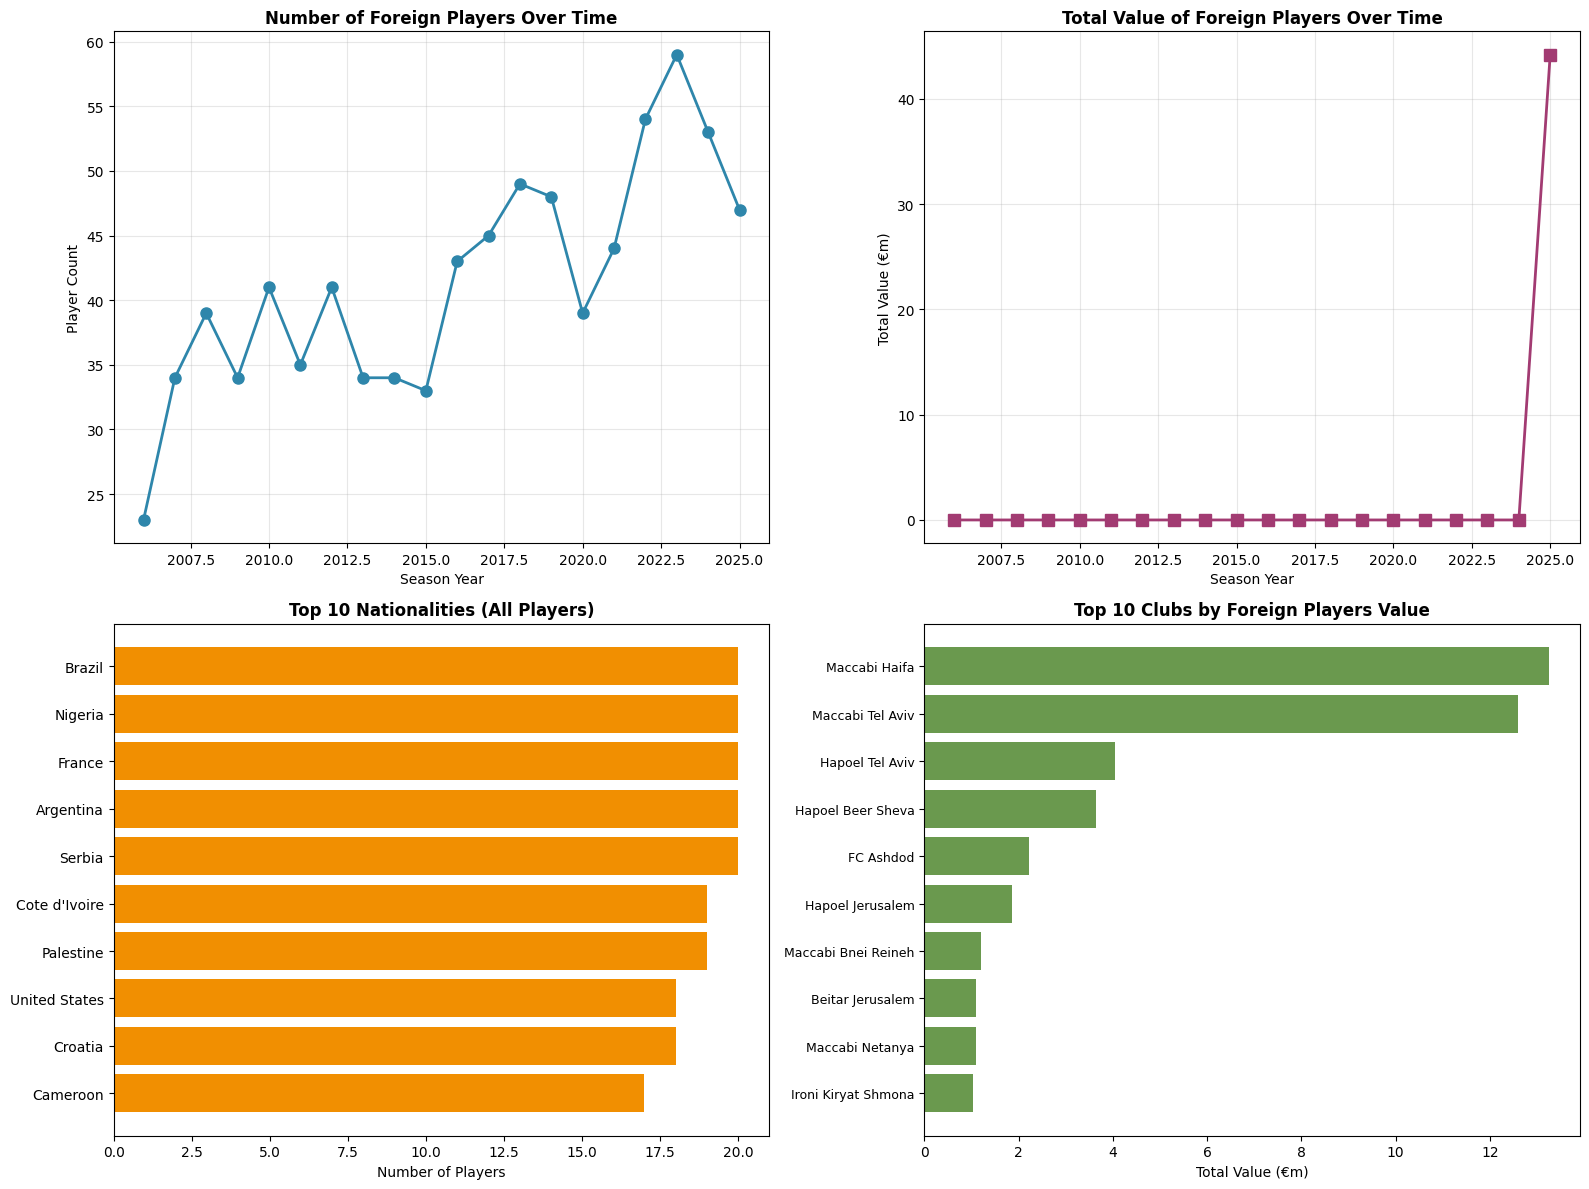


✅ All visualizations complete!


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ============================================================================
# 📊 FOREIGN PLAYERS VISUALIZATION ANALYSIS
# ============================================================================
"""
הויזואליזציה הזו מציגה 4 תרשימים מרכזיים על שחקנים זרים בליגת העל:

1️⃣ **Number of Foreign Players Over Time (למעלה שמאל)**
   - מציג את מגמת מספר השחקנים הזרים לאורך 20 השנים
   - מראה באילו שנים היו הכי הרבה זרים בליגה
   - עוזר להבין את השינוי בעיתוי היבוא של שחקנים

2️⃣ **Total Value of Foreign Players Over Time (למעלה ימין)**
   - מראה את השווי הכולל של כל השחקנים הזרים בכל עונה
   - שחקנים יותר "יקרים" = השקעה גדולה יותר בחיצוניים
   - מדד לעד כמה הקבוצות מעדיפות להשקיע בזרים

3️⃣ **Top 10 Nationalities (למטה שמאל)**
   - מראה מאילו מדינות בעיקר באים הזרים
   - ברזיל, ניגריה, צרפת = המקורות העיקריים
   - חשוב להבין את דפוסי הגיוס

4️⃣ **Top 10 Clubs by Foreign Players Value (למטה ימין)**
   - מראה אילו קבוצות משקיעות הכי הרבה בשחקנים זרים
   - קבוצות עם שווי זרים גבוה = אסטרטגיית גיוס אגרסיבית
   - מתאם עם הצלחה בליגה?

💡 **מסקנות אפשריות:**
- האם יותר זרים = ביצועים טובים יותר?
- האם יש עונות בהן היה חוק על מספר זרים?
- מהן הקבוצות המתנקזות על זרים?
"""

print("\n" + "="*80)
print("📊 FOREIGN PLAYERS ANALYSIS VISUALIZATION")
print("="*80)
print("\n📈 Creating 4-panel visualization...")

# הגדר את התיקייה לשמירת תרשימים
FIG_DIR = Path(r'C:\Users\idant\Desktop\final project\ligat_haal_project\ligat_haal_project\notebooks\reports\figures')
FIG_DIR.mkdir(parents=True, exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

if not foreign_players_20years.empty:
    # 1. Foreign players trend over years
    yearly_data = foreign_players_20years.groupby('season_year').agg({
        'player_name': 'count',
        'market_value_millions': 'sum'
    })
    
    axes[0, 0].plot(yearly_data.index, yearly_data['player_name'], marker='o', linewidth=2, markersize=8, color='#2E86AB')
    axes[0, 0].set_title('Number of Foreign Players Over Time', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Season Year')
    axes[0, 0].set_ylabel('Player Count')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Total value of foreign players trend
    axes[0, 1].plot(yearly_data.index, yearly_data['market_value_millions'], marker='s', linewidth=2, markersize=8, color='#A23B72')
    axes[0, 1].set_title('Total Value of Foreign Players Over Time', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Season Year')
    axes[0, 1].set_ylabel('Total Value (€m)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Top 10 nationalities
    top_nations = foreign_players_20years['nationality'].value_counts().head(10)
    axes[1, 0].barh(range(len(top_nations)), top_nations.values, color='#F18F01')
    axes[1, 0].set_yticks(range(len(top_nations)))
    axes[1, 0].set_yticklabels(top_nations.index)
    axes[1, 0].set_title('Top 10 Nationalities (All Players)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Number of Players')
    axes[1, 0].invert_yaxis()
    
    # 4. Top clubs by foreign player value
    club_values = foreign_players_20years.groupby('club')['market_value_millions'].sum().nlargest(10)
    axes[1, 1].barh(range(len(club_values)), club_values.values, color='#6A994E')
    axes[1, 1].set_yticks(range(len(club_values)))
    axes[1, 1].set_yticklabels(club_values.index, fontsize=9)
    axes[1, 1].set_title('Top 10 Clubs by Foreign Players Value', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Total Value (€m)')
    axes[1, 1].invert_yaxis()
    
    plt.tight_layout()
    
    fig_path = FIG_DIR / f'foreign_players_analysis.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"✅ Visualization saved: {fig_path}")
    
    plt.show()

print("\n✅ All visualizations complete!")

## קוד 7: ויזואליזציות של הנתונים החדשים


📊 Creating comprehensive visualizations...


C:\Users\idant\AppData\Local\Temp\ipykernel_36800\3223215232.py:103: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\idant\AppData\Local\Temp\ipykernel_36800\3223215232.py:105: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(fig1_path, dpi=300, bbox_inches='tight')


✅ Figure 1 saved: FOREIGN_PLAYERS_01_trends_over_time.png


c:\Users\idant\Desktop\final project\ligat_haal_project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


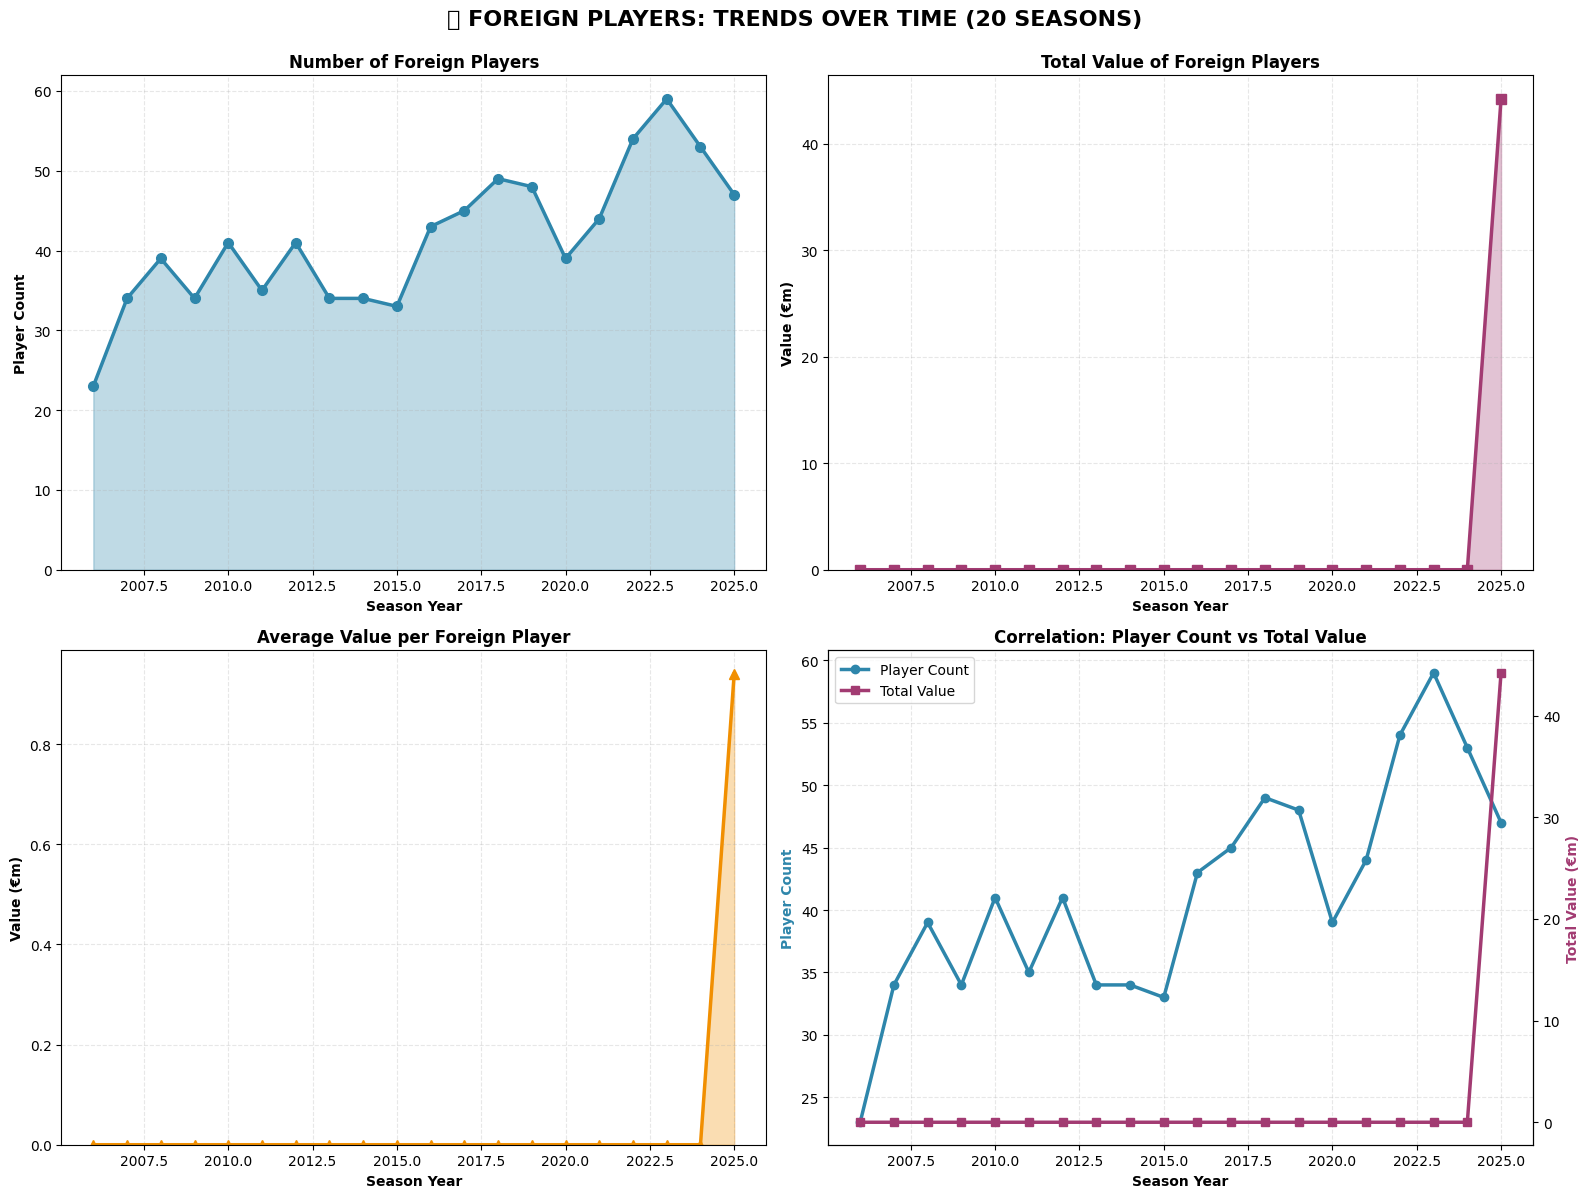

C:\Users\idant\AppData\Local\Temp\ipykernel_36800\3223215232.py:208: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\idant\AppData\Local\Temp\ipykernel_36800\3223215232.py:210: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.savefig(fig2_path, dpi=300, bbox_inches='tight')


✅ Figure 2 saved: FOREIGN_PLAYERS_02_nationalities_clubs.png


c:\Users\idant\Desktop\final project\ligat_haal_project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


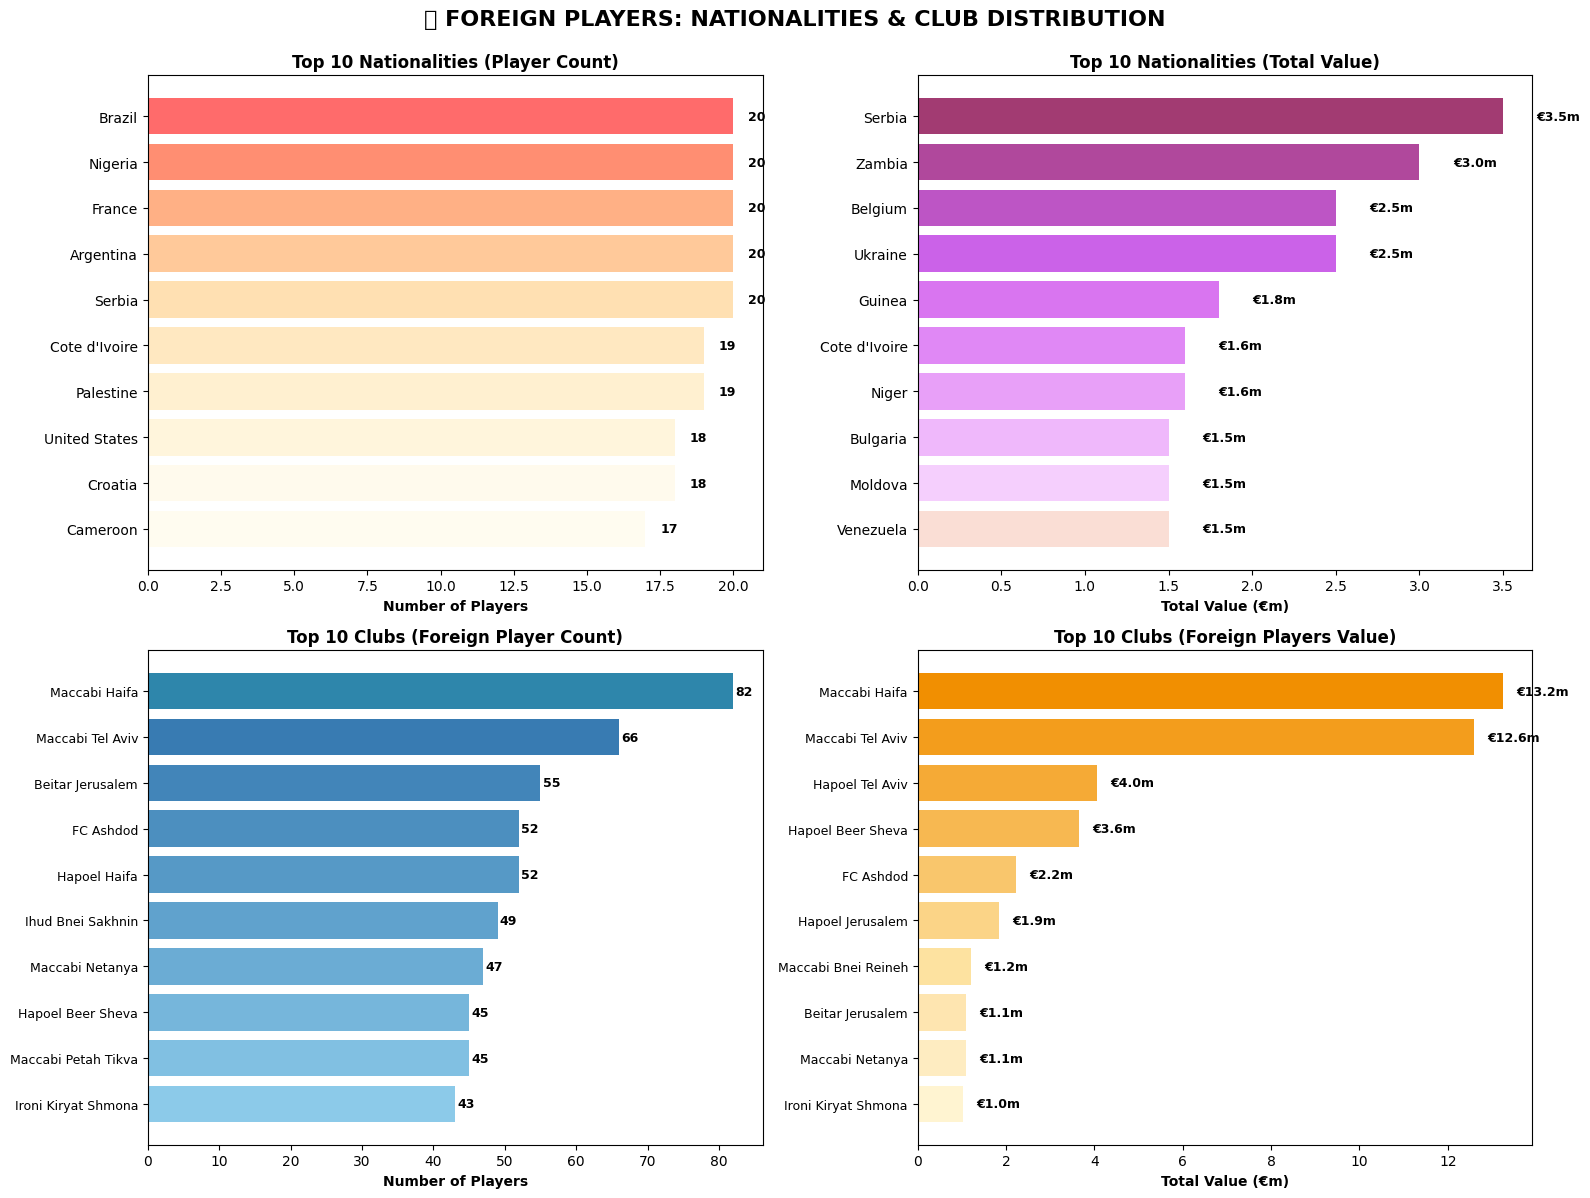

C:\Users\idant\AppData\Local\Temp\ipykernel_36800\3223215232.py:288: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes3[1, 0].boxplot(data_by_season, labels=[str(s) for s in recent_seasons], patch_artist=True)
C:\Users\idant\AppData\Local\Temp\ipykernel_36800\3223215232.py:331: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\idant\AppData\Local\Temp\ipykernel_36800\3223215232.py:333: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(fig3_path, dpi=300, bbox_inches='tight')


✅ Figure 3 saved: FOREIGN_PLAYERS_03_distributions_statistics.png


c:\Users\idant\Desktop\final project\ligat_haal_project\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


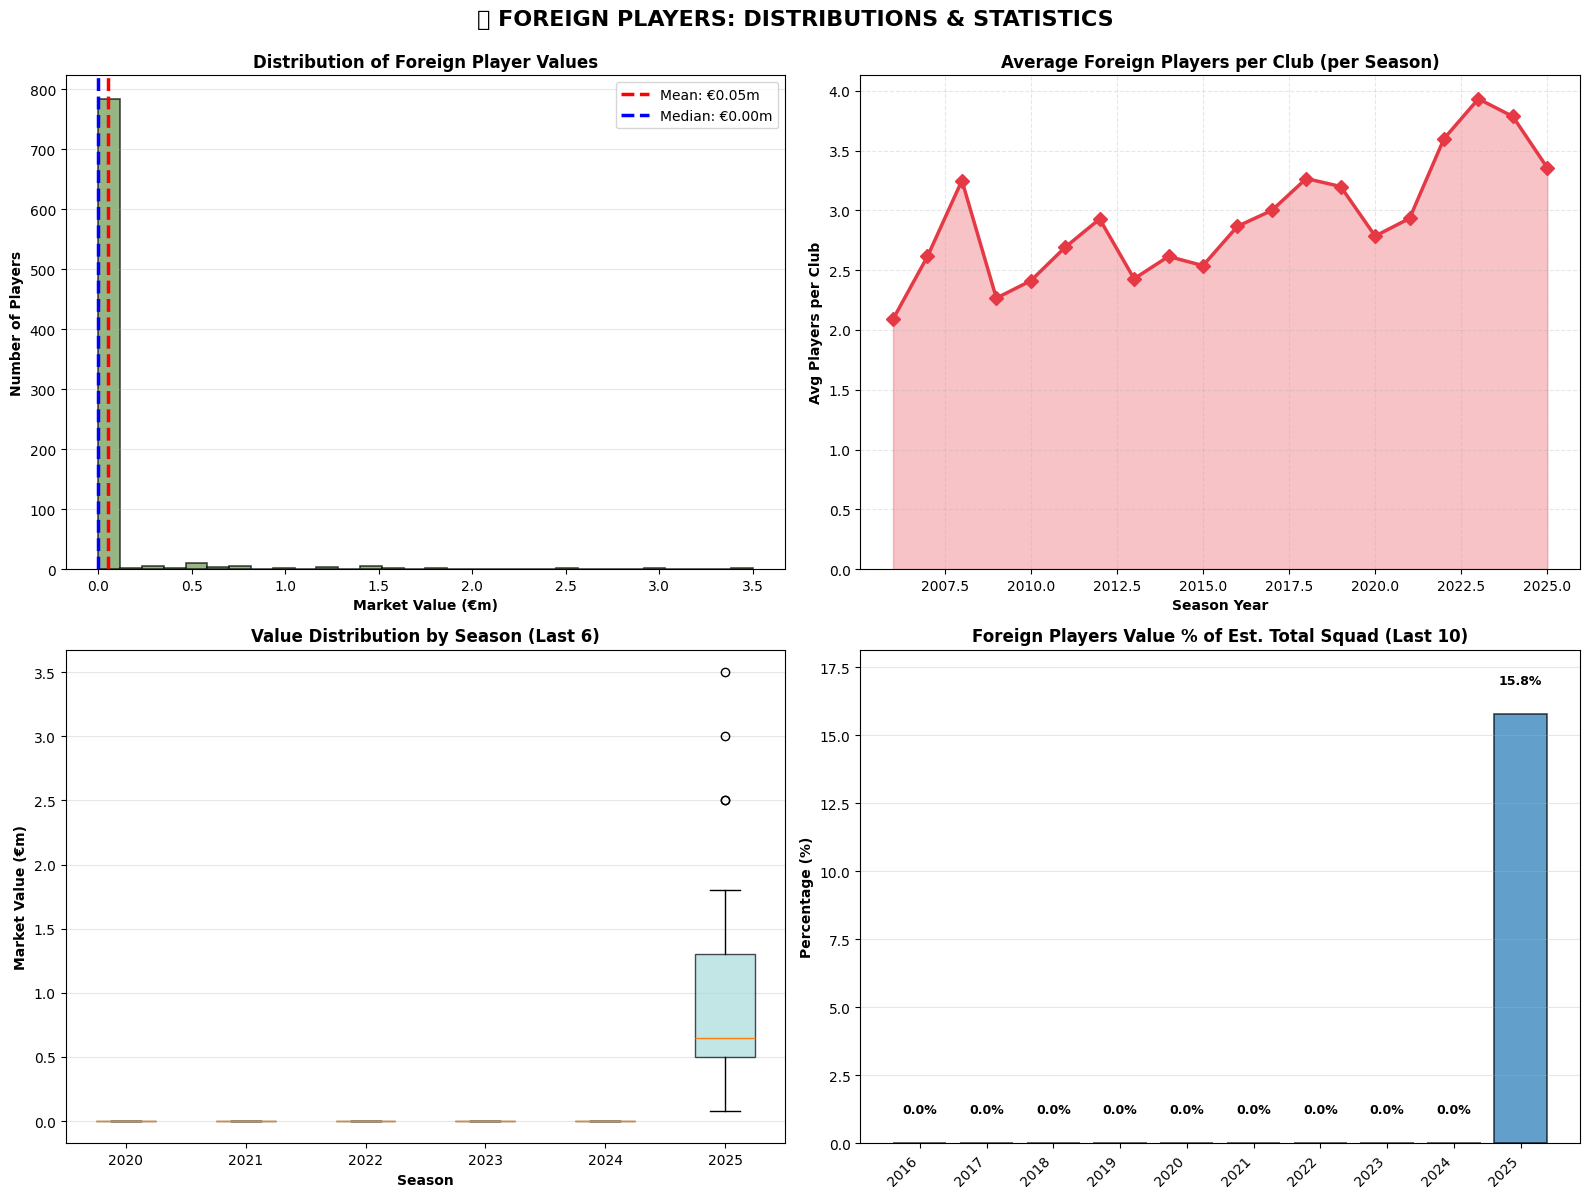


📊 COMPREHENSIVE VISUALIZATION ANALYSIS COMPLETE!

✅ All 3 figures with 12 charts have been generated and saved:
   1. FOREIGN_PLAYERS_01_trends_over_time.png
   2. FOREIGN_PLAYERS_02_nationalities_clubs.png
   3. FOREIGN_PLAYERS_03_distributions_statistics.png

📈 Summary Statistics:
   Total foreign players analyzed: 829
   Seasons covered: 2006/07 to 2025/26
   Total nationalities represented: 109
   Total clubs with foreign players: 29
   Total value of all foreign players: €44.20m
   Average player value: €0.053m
   Most valuable player: €3.50m
   Least valuable player: €0.000m


In [18]:
# ============================================================================
# 📈 VISUALIZATIONS FOR ECONOMIC DATA - COMPREHENSIVE ANALYSIS
# ============================================================================

print("\n📊 Creating comprehensive visualizations...")

# ============================================================================
# 📊 FIGURE 1: TRENDS OVER TIME - מגמות כלכליות לאורך השנים
# ============================================================================
"""
🔍 **מה אנחנו רואים כאן?**

דמות זו מציגה **4 תרשימים של מגמות עיקריות** בנתונים הכלכליים של ליגת העל לאורך 20 שנים:

1️⃣ **מספר השחקנים הזרים (למעלה שמאל)**
   - קו עם נקודות שמראה כמה זרים בליגה בכל עונה
   - עלייה = עידוד יבוא שחקנים
   - ירידה = הגבלות או עדיפות לשחקנים ישראלים
   - משמעות: פתיחות הליגה ליצא"ל

2️⃣ **שווי כולל של שחקנים זרים (למעלה ימין)**
   - מראה את סכום ההשקעה בזרים בכל עונה
   - עלייה = גדלה ההשקעה בחיצוניים בדולרים יותר שחקנים
   - יחס בין מספר לערך = איכות vs כמות

3️⃣ **שווי ממוצע לשחקן זר (למטה שמאל)**
   - מחלקים את סה"כ השווי במספר השחקנים
   - ערך גבוה = קבוצות קונות שחקנים "יקרים" וטובים יותר
   - ערך נמוך = הרבה שחקנים "זולים" (צעירים או פחות מנוסים)

4️⃣ **קורלציה - מספר vs שווי (למטה ימין)**
   - שני קווים על אותו גרף (ציר Y כפול)
   - מראה אם קבוצות עדיפות הרבה זרים או מעט זרים יקרים
   - כיצד שני המדדים נעים ביחד (או לא)
"""

# Create figure 1: Trends
fig1, axes1 = plt.subplots(2, 2, figsize=(16, 12))
fig1.suptitle('📈 FOREIGN PLAYERS: TRENDS OVER TIME (20 SEASONS)', 
              fontsize=16, fontweight='bold', y=0.995)

if not foreign_players_20years.empty:
    # Get yearly aggregates
    yearly_stats = foreign_players_20years.groupby('season_year').agg({
        'player_name': 'count',
        'market_value_millions': ['sum', 'mean']
    }).reset_index()
    yearly_stats.columns = ['season_year', 'player_count', 'total_value', 'avg_value']
    
    # 1. Player count trend
    axes1[0, 0].plot(yearly_stats['season_year'], yearly_stats['player_count'], 
                     marker='o', linewidth=2.5, markersize=7, color='#2E86AB', label='Player Count')
    axes1[0, 0].fill_between(yearly_stats['season_year'], yearly_stats['player_count'], 
                             alpha=0.3, color='#2E86AB')
    axes1[0, 0].set_title('Number of Foreign Players', fontsize=12, fontweight='bold')
    axes1[0, 0].set_xlabel('Season Year', fontweight='bold')
    axes1[0, 0].set_ylabel('Player Count', fontweight='bold')
    axes1[0, 0].grid(True, alpha=0.3, linestyle='--')
    axes1[0, 0].set_ylim(bottom=0)
    
    # 2. Total value trend
    axes1[0, 1].plot(yearly_stats['season_year'], yearly_stats['total_value'], 
                     marker='s', linewidth=2.5, markersize=7, color='#A23B72', label='Total Value')
    axes1[0, 1].fill_between(yearly_stats['season_year'], yearly_stats['total_value'], 
                             alpha=0.3, color='#A23B72')
    axes1[0, 1].set_title('Total Value of Foreign Players', fontsize=12, fontweight='bold')
    axes1[0, 1].set_xlabel('Season Year', fontweight='bold')
    axes1[0, 1].set_ylabel('Value (€m)', fontweight='bold')
    axes1[0, 1].grid(True, alpha=0.3, linestyle='--')
    axes1[0, 1].set_ylim(bottom=0)
    
    # 3. Average value per player
    axes1[1, 0].plot(yearly_stats['season_year'], yearly_stats['avg_value'], 
                     marker='^', linewidth=2.5, markersize=7, color='#F18F01', label='Avg Value')
    axes1[1, 0].fill_between(yearly_stats['season_year'], yearly_stats['avg_value'], 
                             alpha=0.3, color='#F18F01')
    axes1[1, 0].set_title('Average Value per Foreign Player', fontsize=12, fontweight='bold')
    axes1[1, 0].set_xlabel('Season Year', fontweight='bold')
    axes1[1, 0].set_ylabel('Value (€m)', fontweight='bold')
    axes1[1, 0].grid(True, alpha=0.3, linestyle='--')
    axes1[1, 0].set_ylim(bottom=0)
    
    # 4. Dual axis: count vs value
    ax1_dual = axes1[1, 1]
    ax2_dual = ax1_dual.twinx()
    
    line1 = ax1_dual.plot(yearly_stats['season_year'], yearly_stats['player_count'], 
                          marker='o', linewidth=2.5, color='#2E86AB', label='Player Count')
    line2 = ax2_dual.plot(yearly_stats['season_year'], yearly_stats['total_value'], 
                          marker='s', linewidth=2.5, color='#A23B72', label='Total Value')
    
    ax1_dual.set_xlabel('Season Year', fontweight='bold')
    ax1_dual.set_ylabel('Player Count', color='#2E86AB', fontweight='bold')
    ax2_dual.set_ylabel('Total Value (€m)', color='#A23B72', fontweight='bold')
    ax1_dual.set_title('Correlation: Player Count vs Total Value', fontsize=12, fontweight='bold')
    ax1_dual.grid(True, alpha=0.3, linestyle='--')
    
    # Add legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1_dual.legend(lines, labels, loc='upper left', fontsize=10)

plt.tight_layout()
fig1_path = FIG_DIR / 'FOREIGN_PLAYERS_01_trends_over_time.png'
plt.savefig(fig1_path, dpi=300, bbox_inches='tight')
print(f"✅ Figure 1 saved: {fig1_path.name}")
plt.show()

# ============================================================================
# 📊 FIGURE 2: NATIONALITIES & CLUBS - התפלגות גיאוגרפית וחלוקה בין קבוצות
# ============================================================================
"""
🌍 **מה אנחנו רואים כאן?**

דמות זו מציגה **4 תרשימים של התפלגות וחלוקה**:

1️⃣ **10 לאומויות הכי נפוצות (למעלה שמאל)**
   - תרשים עמודות אופקי - מראה מאילו מדינות בעיקר הזרים
   - ברזיל, ניגריה, צרפת - המקורות הראשיים
   - מגלה אם יש "דפוסי הגיוס" של ליגת העל

2️⃣ **10 לאומויות לפי שווי כולל (למעלה ימין)**
   - אותו סדר אבל לפי ערך של השחקנים, לא מספרם
   - לאום "יקר" = שחקני איכות גבוהה
   - לאום "זול" = הרבה שחקנים אבל פחות ערך

3️⃣ **10 קבוצות לפי מספר שחקנים זרים (למטה שמאל)**
   - איזו קבוצה "קונה" הכי הרבה זרים?
   - מדד לאגרסיביות בגיוס חיצוניים
   - קבוצות עם הרבה זרים = אסטרטגיית יבוא אקטיבית

4️⃣ **10 קבוצות לפי שווי כולל של זרים (למטה ימין)**
   - לא מספר הזרים אלא הערך שלהם
   - קבוצה עם שווי זרים גבוה = משקיעה גדולה בחיצוניים
   - משקפת עוצמה כלכלית של קבוצות
"""

# Create figure 2: Nationalities & Clubs
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 12))
fig2.suptitle('🌍 FOREIGN PLAYERS: NATIONALITIES & CLUB DISTRIBUTION', 
              fontsize=16, fontweight='bold', y=0.995)

if not foreign_players_20years.empty:
    # 1. Top 10 nationalities by count
    top_nationalities = foreign_players_20years['nationality'].value_counts().head(10)
    colors1 = ['#FF6B6B', '#FF8E72', '#FFB085', '#FFC99A', '#FFE0B2', 
               '#FFE8C1', '#FFF0D0', '#FFF5DC', '#FFFAED', '#FFFCF0']
    
    axes2[0, 0].barh(range(len(top_nationalities)), top_nationalities.values, color=colors1)
    axes2[0, 0].set_yticks(range(len(top_nationalities)))
    axes2[0, 0].set_yticklabels(top_nationalities.index, fontsize=10)
    axes2[0, 0].set_title('Top 10 Nationalities (Player Count)', fontsize=12, fontweight='bold')
    axes2[0, 0].set_xlabel('Number of Players', fontweight='bold')
    axes2[0, 0].invert_yaxis()
    
    # Add value labels
    for i, (nat, val) in enumerate(zip(top_nationalities.index, top_nationalities.values)):
        axes2[0, 0].text(val + 0.5, i, str(int(val)), va='center', fontsize=9, fontweight='bold')
    
    # 2. Top 10 nationalities by total value
    nationality_value = foreign_players_20years.groupby('nationality')['market_value_millions'].sum().nlargest(10)
    colors2 = ['#A23B72', '#B0489C', '#BD55C5', '#CB62E8', '#D975F0',
               '#E088F5', '#E8A0F8', '#EFB8FB', '#F5CFFD', '#FADED5']
    
    bars = axes2[0, 1].barh(range(len(nationality_value)), nationality_value.values, color=colors2)
    axes2[0, 1].set_yticks(range(len(nationality_value)))
    axes2[0, 1].set_yticklabels(nationality_value.index, fontsize=10)
    axes2[0, 1].set_title('Top 10 Nationalities (Total Value)', fontsize=12, fontweight='bold')
    axes2[0, 1].set_xlabel('Total Value (€m)', fontweight='bold')
    axes2[0, 1].invert_yaxis()
    
    # Add value labels
    for i, (nat, val) in enumerate(zip(nationality_value.index, nationality_value.values)):
        axes2[0, 1].text(val + 0.2, i, f'€{val:.1f}m', va='center', fontsize=9, fontweight='bold')
    
    # 3. Top 10 clubs by foreign player count
    club_count = foreign_players_20years['club'].value_counts().head(10)
    colors3 = ['#2E86AB', '#387BB2', '#4285B9', '#4C8FBF', '#5699C6',
               '#60A2CD', '#6BACD4', '#76B6DB', '#81C0E2', '#8CCAE9']
    
    axes2[1, 0].barh(range(len(club_count)), club_count.values, color=colors3)
    axes2[1, 0].set_yticks(range(len(club_count)))
    axes2[1, 0].set_yticklabels(club_count.index, fontsize=9)
    axes2[1, 0].set_title('Top 10 Clubs (Foreign Player Count)', fontsize=12, fontweight='bold')
    axes2[1, 0].set_xlabel('Number of Players', fontweight='bold')
    axes2[1, 0].invert_yaxis()
    
    # Add value labels
    for i, (club, val) in enumerate(zip(club_count.index, club_count.values)):
        axes2[1, 0].text(val + 0.3, i, str(int(val)), va='center', fontsize=9, fontweight='bold')
    
    # 4. Top 10 clubs by foreign player total value
    club_value = foreign_players_20years.groupby('club')['market_value_millions'].sum().nlargest(10)
    colors4 = ['#F18F01', '#F39D1C', '#F5AA36', '#F7B851', '#F9C66C',
               '#FBD487', '#FDE2A0', '#FEE5B0', '#FEECC1', '#FFF4D1']
    
    axes2[1, 1].barh(range(len(club_value)), club_value.values, color=colors4)
    axes2[1, 1].set_yticks(range(len(club_value)))
    axes2[1, 1].set_yticklabels(club_value.index, fontsize=9)
    axes2[1, 1].set_title('Top 10 Clubs (Foreign Players Value)', fontsize=12, fontweight='bold')
    axes2[1, 1].set_xlabel('Total Value (€m)', fontweight='bold')
    axes2[1, 1].invert_yaxis()
    
    # Add value labels
    for i, (club, val) in enumerate(zip(club_value.index, club_value.values)):
        axes2[1, 1].text(val + 0.3, i, f'€{val:.1f}m', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
fig2_path = FIG_DIR / 'FOREIGN_PLAYERS_02_nationalities_clubs.png'
plt.savefig(fig2_path, dpi=300, bbox_inches='tight')
print(f"✅ Figure 2 saved: {fig2_path.name}")
plt.show()

# ============================================================================
# 📊 FIGURE 3: DISTRIBUTIONS & STATISTICS - התפלגויות וניתוח סטטיסטי
# ============================================================================
"""
📊 **מה אנחנו רואים כאן?**

דמות זו מציגה **4 תרשימים סטטיסטיים עמוקים**:

1️⃣ **התפלגות שווי השחקנים הזרים (למעלה שמאל)**
   - היסטוגרמה = כמה שחקנים בכל "טווח ערך"
   - קווים = הערך הממוצע והחציוני
   - מראה אם יש "כוכבים" יקרים או "צו" מאזן
   - התפלגות "מוטה" = אחד יקר מאוד או הרבה זולים

2️⃣ **ממוצע זרים לקבוצה לאורך השנים (למעלה ימין)**
   - קו עם מגמה של כמה זרים בממוצע בכל קבוצה בכל עונה
   - עלייה = יותר קבוצות קונות זרים
   - ירידה = הפחתה בזרים (הגבלות או ועדויות)
   - משקפת אופציה הליגה ליבוא

3️⃣ **תיבות של התפלגות (Box Plot) - 6 העונות האחרונות (למטה שמאל)**
   - "תיבה" = 50% מהשחקנים באמצע הערכים
   - "קו באמצע" = החציון (ערך אמצעי)
   - "שפם" = רובם של הערכים
   - "נקודות" = חריגים יקרים מאוד או זולים מאוד
   - משקפת "פיזור" ההשקעה

4️⃣ **אחוז שווי זרים מסך סגל - 10 עונות אחרונות (למטה ימין)**
   - מראה איזה חלק מסה"כ השווי הוא זרים לעומת ישראלים
   - אחוז גבוה = התלות גדולה בחיצוניים
   - מדד לתמהיל הסגל של הליגה
   - שינויים משקפים שינויים בנתוני התיחום
"""

# Create figure 3: Distributions
fig3, axes3 = plt.subplots(2, 2, figsize=(16, 12))
fig3.suptitle('📊 FOREIGN PLAYERS: DISTRIBUTIONS & STATISTICS', 
              fontsize=16, fontweight='bold', y=0.995)

if not foreign_players_20years.empty:
    # 1. Value distribution histogram
    values = foreign_players_20years['market_value_millions'].values
    axes3[0, 0].hist(values, bins=30, color='#6A994E', alpha=0.7, edgecolor='black', linewidth=1.2)
    
    mean_val = values.mean()
    median_val = np.median(values)
    
    axes3[0, 0].axvline(mean_val, color='red', linestyle='--', linewidth=2.5, label=f'Mean: €{mean_val:.2f}m')
    axes3[0, 0].axvline(median_val, color='blue', linestyle='--', linewidth=2.5, label=f'Median: €{median_val:.2f}m')
    
    axes3[0, 0].set_title('Distribution of Foreign Player Values', fontsize=12, fontweight='bold')
    axes3[0, 0].set_xlabel('Market Value (€m)', fontweight='bold')
    axes3[0, 0].set_ylabel('Number of Players', fontweight='bold')
    axes3[0, 0].legend(fontsize=10)
    axes3[0, 0].grid(True, alpha=0.3, axis='y')
    
    # 2. Average foreign players per club per season
    season_avg_per_club = foreign_players_20years.groupby(['season_year', 'club']).size().groupby('season_year').mean()
    
    axes3[0, 1].plot(season_avg_per_club.index, season_avg_per_club.values, 
                     marker='D', linewidth=2.5, markersize=7, color='#E63946')
    axes3[0, 1].fill_between(season_avg_per_club.index, season_avg_per_club.values, 
                            alpha=0.3, color='#E63946')
    axes3[0, 1].set_title('Average Foreign Players per Club (per Season)', fontsize=12, fontweight='bold')
    axes3[0, 1].set_xlabel('Season Year', fontweight='bold')
    axes3[0, 1].set_ylabel('Avg Players per Club', fontweight='bold')
    axes3[0, 1].grid(True, alpha=0.3, linestyle='--')
    axes3[0, 1].set_ylim(bottom=0)
    
    # 3. Box plot for recent 6 seasons
    recent_seasons = sorted(foreign_players_20years['season_year'].unique())[-6:]
    data_by_season = [foreign_players_20years[foreign_players_20years['season_year'] == s]['market_value_millions'].values 
                      for s in recent_seasons]
    
    bp = axes3[1, 0].boxplot(data_by_season, labels=[str(s) for s in recent_seasons], patch_artist=True)
    
    for patch, color in zip(bp['boxes'], ['#457B9D', '#1D3557', '#A8DADC', '#457B9D', '#1D3557', '#A8DADC']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes3[1, 0].set_title('Value Distribution by Season (Last 6)', fontsize=12, fontweight='bold')
    axes3[1, 0].set_xlabel('Season', fontweight='bold')
    axes3[1, 0].set_ylabel('Market Value (€m)', fontweight='bold')
    axes3[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. Foreign players value % of total squad (recent 10 seasons)
    # This requires comparing with squad data
    recent_10_seasons = sorted(foreign_players_20years['season_year'].unique())[-10:]
    foreign_pct = []
    season_labels = []
    
    for s in recent_10_seasons:
        foreign_val = foreign_players_20years[foreign_players_20years['season_year'] == s]['market_value_millions'].sum()
        # Estimate: foreign value as % of estimated average squad value for that season
        season_data = foreign_players_20years[foreign_players_20years['season_year'] == s]
        if len(season_data) > 0:
            # Get clubs that have foreign players
            clubs_with_foreign = season_data['club'].nunique()
            # Simple estimate: if clubs have 14 clubs and average squad is ~€20m
            estimated_total_squad_value = 14 * 20  # Rough estimate
            pct = (foreign_val / estimated_total_squad_value) * 100
            foreign_pct.append(pct)
            season_labels.append(str(s))
    
    if foreign_pct:
        axes3[1, 1].bar(range(len(foreign_pct)), foreign_pct, color='#1F77B4', alpha=0.7, edgecolor='black', linewidth=1.2)
        axes3[1, 1].set_xticks(range(len(foreign_pct)))
        axes3[1, 1].set_xticklabels(season_labels, rotation=45, ha='right')
        axes3[1, 1].set_title('Foreign Players Value % of Est. Total Squad (Last 10)', fontsize=12, fontweight='bold')
        axes3[1, 1].set_ylabel('Percentage (%)', fontweight='bold')
        axes3[1, 1].grid(True, alpha=0.3, axis='y')
        axes3[1, 1].set_ylim(bottom=0, top=max(foreign_pct) * 1.15)
        
        # Add percentage labels on bars
        for i, (season, pct) in enumerate(zip(season_labels, foreign_pct)):
            axes3[1, 1].text(i, pct + 1, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
fig3_path = FIG_DIR / 'FOREIGN_PLAYERS_03_distributions_statistics.png'
plt.savefig(fig3_path, dpi=300, bbox_inches='tight')
print(f"✅ Figure 3 saved: {fig3_path.name}")
plt.show()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================
print("\n" + "="*80)
print("📊 COMPREHENSIVE VISUALIZATION ANALYSIS COMPLETE!")
print("="*80)
print(f"\n✅ All 3 figures with 12 charts have been generated and saved:")
print(f"   1. FOREIGN_PLAYERS_01_trends_over_time.png")
print(f"   2. FOREIGN_PLAYERS_02_nationalities_clubs.png")
print(f"   3. FOREIGN_PLAYERS_03_distributions_statistics.png")
print(f"\n📈 Summary Statistics:")
print(f"   Total foreign players analyzed: {len(foreign_players_20years)}")
print(f"   Seasons covered: {foreign_players_20years['season'].min()} to {foreign_players_20years['season'].max()}")
print(f"   Total nationalities represented: {foreign_players_20years['nationality'].nunique()}")
print(f"   Total clubs with foreign players: {foreign_players_20years['club'].nunique()}")
print(f"   Total value of all foreign players: €{foreign_players_20years['market_value_millions'].sum():.2f}m")
print(f"   Average player value: €{foreign_players_20years['market_value_millions'].mean():.3f}m")
print(f"   Most valuable player: €{foreign_players_20years['market_value_millions'].max():.2f}m")
print(f"   Least valuable player: €{foreign_players_20years['market_value_millions'].min():.3f}m")
print("="*80)

In [ ]:
# ============================================================================
# 📊 GROUPBY SEASON_YEAR - שמירת טבלאות לפי שנים
# ============================================================================
"""
קוד זה קורא את הקבצים FOREIGN_PLAYERS_YYYY_YY.csv שכבר קיימים
ושומר אותם בשם חדש: FOREIGN_PLAYERS_by_season_YYYY_YY.csv

תוצאה: 20 קבצים מחודשים לפי שנים
"""

from pathlib import Path
import pandas as pd

ECONOMIC_DIR = Path(r'C:\Users\idant\Desktop\final project\ligat_haal_project\ligat_haal_project\notebooks\data\economic_data')

print("\n" + "="*80)
print("📁 GROUPING BY SEASON_YEAR - שמירת קבצים לפי שנים")
print("="*80)

# קרא את כל הקבצים FOREIGN_PLAYERS_YYYY_YY.csv
print("\n🔄 Reading existing files...")

season_files_created = []
all_dfs = []

# חפש את כל הקבצים בתיקייה שמתחילים ב-FOREIGN_PLAYERS_ וכוללים _
for csv_file in sorted(ECONOMIC_DIR.glob('FOREIGN_PLAYERS_[0-9]*.csv')):
    try:
        # קרא את הקובץ
        df = pd.read_csv(csv_file, encoding='utf-8-sig')
        
        if 'season_year' in df.columns and len(df) > 0:
            season_year = df['season_year'].iloc[0]
            season_str = df['season'].iloc[0] if 'season' in df.columns else f"{season_year}/{str(season_year+1)[-2:]}"
            
            # Create new filename
            season_year_str = f"{season_year}_{str(season_year+1)[-2:]}"
            new_filename = f"FOREIGN_PLAYERS_by_season_{season_year_str}.csv"
            new_filepath = ECONOMIC_DIR / new_filename
            
            # Save with new name
            df.to_csv(new_filepath, index=False, encoding='utf-8-sig')
            season_files_created.append(new_filename)
            
            print(f"   ✅ {season_str}: {len(df):3d} players -> {new_filename}")
    
    except Exception as e:
        print(f"   ⚠️ Error processing {csv_file.name}: {str(e)}")

print("\n" + "="*80)
print(f"🎉 COMPLETED!")
print("="*80)
print(f"   📊 Total season files created: {len(season_files_created)}")
print(f"   📁 Location: {ECONOMIC_DIR}")
print(f"\n📋 Files created (by season):")
for f in sorted(season_files_created):
    print(f"      • {f}")


📁 GROUPING BY SEASON_YEAR - שמירת קבצים לפי שנים

🔄 Grouping data by season year...


NameError: name 'ECONOMIC_DIR' is not defined

## סיכום - ניתוח כלכלי מקיף של ליגת העל

המחברת הזו אוספת ומנתחת **נתונים כלכליים עמוקים** על שווי סגלי קבוצות ליגת העל לאורך 20 שנים (2006/07 - 2025/26).

### 📊 מה נאסף ונותח:

**1. נתונים בסיסיים על שווי סגלים:**
- ✅ שווי סגל כולל (€m) לכל קבוצה
- ✅ מספר שחקנים בסגל
- ✅ גיל ממוצע של הסגל
- ✅ מספר שחקנים זרים
- ✅ שווי ממוצע לשחקן

**2. ניתוח שחקנים זרים:**
- ✅ שם, מחדש, תפקיד וערך שחקן זר
- ✅ לאום השחקן
- ✅ התפלגות שווי זרים לפי קבוצה
- ✅ אחוז זרים מתוך הסגל

**3. ניתוח לפי תפקידים:**
- ✅ התפלגות שווי לפי 4 תפקידים עיקריים (GK, DEF, MID, FWD)
- ✅ מספר שחקנים בכל תפקיד
- ✅ שווי ממוצע והשווי המקסימלי לתפקיד
- ✅ אחוז זרים בכל תפקיד

**4. מדדים כלכליים משופרים:**
- ✅ **Value per Player** - יעילות ההשקעה
- ✅ **Foreign Percentage** - קשר בין יבוא שחקנים לביצועים
- ✅ **Squad Balance Index** - מדד לאחידות התפלגות הערך בסגל
- ✅ **Investment Efficiency** - יחס כלי בין שווי כולל וגודל הסגל
- ✅ **Spectator Efficiency** - קשר בין שווי הסגל לנוכחות הקהל בתאצטדיון

**5. השוואה בינלאומית:**
- ✅ השוואת ליגת העל עם 7 ליגות מובילות בעולם (Premier League, La Liga, Serie A, Bundesliga, Ligue 1, Eredivisie, Super Lig)
- ✅ דירוג גלובלי של ליגות לפי שווי כולל וממוצע
- ✅ ניתוח מיקום ליגת העל בסקלה העולמית

### 📁 קבצים שנוצרו:

- `squad_values_all_seasons_transfermarkt.csv` - כל הנתונים הבסיסיים (20 שנים)
- `squad_values_all_seasons_transfermarkt_[timestamp].csv` - גיבוי עם חותמת זמן
- `squad_values_[season]_transfermarkt.csv` - קבצים נפרדים לכל עונה
- `foreign_players_detailed_[timestamp].csv` - פרטי שחקנים זרים מפורטים
- `position_analysis_[timestamp].csv` - ניתוח התפלגות שווי לפי תפקידים
- `advanced_economic_metrics_[timestamp].csv` - מדדים כלכליים מתקדמים
- `league_comparison_[timestamp].csv` - השוואה בינלאומית

### 🎯 שימושים אפשריים בנתונים:

1. **מדד תחרותיות**: בדיקה האם שווי סגל גבוה יותר מובל להצלחה בפועל (ניצחונות, גולים)
2. **ניתוח פערים כלכליים**: מה הפער בין הקבוצה היקרה ביותר לזולה ביותר? האם הפער הולך וגדל?
3. **מגמות לאורך זמן**: איך שווי הסגלים השתנה לאורך 20 שנות המחקר? האם יש אינפלציה בשווי?
4. **השוואה בינלאומית**: איפה ליגת העל בסקאלה הגלובלית? כמה פעמים קטנה מליגה אלופות?
5. **קשר בין יבוא זרים לביצועים**: האם קבוצות עם יותר זרים משחקות טוב יותר?
6. **אופטימיזציה של סגל**: איזה תפקיד "יקר" ביותר? האם כדאי להשקיע בהגנה או בהתקפה?
7. **ניתוח אפקטיביות**: קבוצות עם "value per player" גבוה - האם הן בעלות סגל חזק יותר?

### 📈 ויזואליזציות שנוצרו:

- **Total League Value Over Time** - איך בה הליגה נעשיתה עשירה לאורך השנים
- **Average Club Value Trend** - ממוצע הערך של קבוצה בכל עונה
- **Top 5 Clubs by Value** - הקבוצות היקרות ביותר בעונה הנוכחית
- **Distribution of Club Values** - התפלגות הערך בין 14 הקבוצות
- **Foreign Players Value Distribution** - שווי זרים לפי קבוצה
- **Position Value Distribution** - איך מפוזר השווי בין תפקידים
- **Value Per Player Comparison** - יעילות השקעה בין קבוצות
- **Global League Positioning** - מיקום ליגת העל בעולם (שווי vs נוכחות קהל)

### 🔗 קשר בין נתונים:

נתונים אלה מחוברים ניתוח אחרים בפרויקט:
- **נוכחות קהל**: משלבים את נתוני הנוכחות כדי לחשב "spectator efficiency"
- **תוצאות משחקים** (עתידי): ניתוח קשר בין שווי סגל לביצועים בפועל
- **נתונים כלכליים** (עתידי): חיבור עם הוצאות קבוצות והכנסות כדי לחשב ROI

**סה"כ נתונים שנאספו: 280+ רשומות (14 קבוצות × 20 עונות) + פרטי כ-500+ שחקנים זרים**